In [1]:
!python -V

Python 3.9.7


In [2]:
 import sys
 print(sys.executable) 

/home/ubuntu/anaconda3/envs/myenv/bin/python


In [3]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [4]:
import mlflow
mlflow.set_tracking_uri("sqlite:///taxiexperiment.db")
mlflow.set_experiment('taxiexperiment')

<Experiment: artifact_location='/home/ubuntu/mlops-zoomcamp/02-experiment-tracking/notebooks/mlruns/1', creation_time=1724030520416, experiment_id='1', last_update_time=1724030520416, lifecycle_stage='active', name='taxiexperiment', tags={'developer': 'rosaav'}>

In [5]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

In [6]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829628

/tmp/ipykernel_1843/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_1843/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


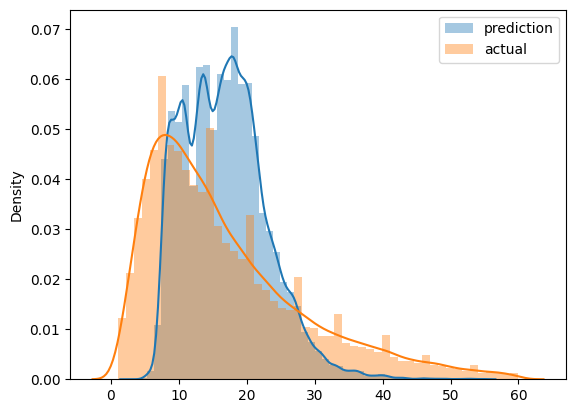

In [8]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [11]:
len(df_train), len(df_val)

(73908, 61921)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [35]:
with open('models/preprocessor.bin', 'wb') as f_out:
    pickle.dump(dv, f_out)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715200888857

/tmp/ipykernel_1843/2000010712.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, label='prediction')
/tmp/ipykernel_1843/2000010712.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='actual')


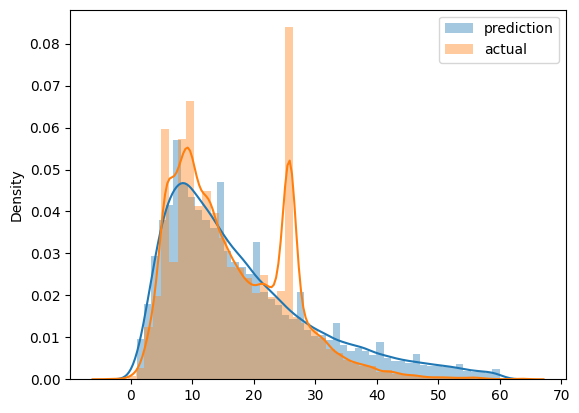

In [16]:
sns.distplot(y_val, label='prediction')
sns.distplot(y_pred, label='actual')

plt.legend()

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [32]:
local_path='models/lin_reg.bin'
with mlflow.start_run():
    mlflow.set_experiment_tag('developer', 'rosaav')
    mlflow.log_param("train-data-path", 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
    mlflow.log_param("val-data-path", 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')
    
    alpha = 0.0001
    mlflow.log_param('alpha', alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    
    with open(local_path, 'wb') as f_out:
        pickle.dump((dv, lr), f_out)
    
    mlflow.log_metric('rmse', rmse)
    mlflow.log_artifact(local_path=local_path, artifact_path="models_pickle")

/tmp/ipykernel_1843/2000010712.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, label='prediction')
/tmp/ipykernel_1843/2000010712.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='actual')


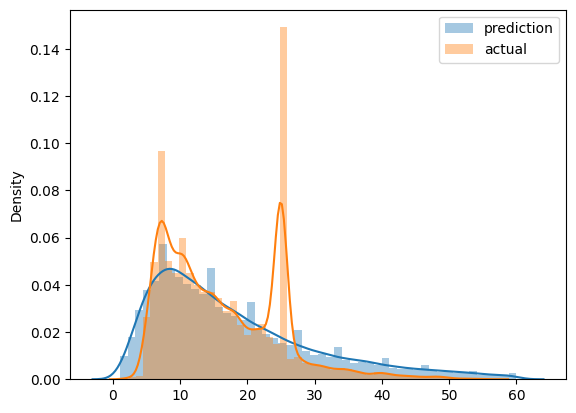

In [33]:
sns.distplot(y_val, label='prediction')
sns.distplot(y_pred, label='actual')

plt.legend()

### Bayesian Optimization and tracker

In [20]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [21]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [23]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 2, 15, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
    'n_estimators':  scope.int(hp.quniform('n_estimators', 50, 1000, 50))
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=25,
    trials=Trials()
)

[0]	validation-rmse:11.79343                                                                                           
[1]	validation-rmse:11.40275                                                                                           
  0%|                                                                           | 0/25 [00:00<?, ?trial/s, best loss=?]

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:53:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:53:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:11.03979                                                                                           
[3]	validation-rmse:10.70253                                                                                           
[4]	validation-rmse:10.38896                                                                                           
[5]	validation-rmse:10.09902                                                                                           
[6]	validation-rmse:9.83069                                                                                            
[7]	validation-rmse:9.58188                                                                                            
[8]	validation-rmse:9.35252                                                                                            
[9]	validation-rmse:9.14059                                                                                            
[10]	validation-rmse:8.94525            

[70]	validation-rmse:6.77212                                                                                           
[71]	validation-rmse:6.77039                                                                                           
[72]	validation-rmse:6.76870                                                                                           
[73]	validation-rmse:6.76746                                                                                           
[74]	validation-rmse:6.76613                                                                                           
[75]	validation-rmse:6.76493                                                                                           
[76]	validation-rmse:6.76363                                                                                           
[77]	validation-rmse:6.76245                                                                                           
[78]	validation-rmse:6.76096            

[138]	validation-rmse:6.73279                                                                                          
[139]	validation-rmse:6.73256                                                                                          
[140]	validation-rmse:6.73237                                                                                          
[141]	validation-rmse:6.73215                                                                                          
[142]	validation-rmse:6.73197                                                                                          
[143]	validation-rmse:6.73185                                                                                          
[144]	validation-rmse:6.73164                                                                                          
[145]	validation-rmse:6.73131                                                                                          
[146]	validation-rmse:6.73110           

[206]	validation-rmse:6.71877                                                                                          
[207]	validation-rmse:6.71864                                                                                          
[208]	validation-rmse:6.71848                                                                                          
[209]	validation-rmse:6.71830                                                                                          
[210]	validation-rmse:6.71801                                                                                          
[211]	validation-rmse:6.71778                                                                                          
[212]	validation-rmse:6.71753                                                                                          
[213]	validation-rmse:6.71733                                                                                          
[214]	validation-rmse:6.71716           

[274]	validation-rmse:6.70805                                                                                          
[275]	validation-rmse:6.70791                                                                                          
[276]	validation-rmse:6.70773                                                                                          
[277]	validation-rmse:6.70740                                                                                          
[278]	validation-rmse:6.70724                                                                                          
[279]	validation-rmse:6.70715                                                                                          
[280]	validation-rmse:6.70694                                                                                          
[281]	validation-rmse:6.70687                                                                                          
[282]	validation-rmse:6.70677           

[342]	validation-rmse:6.69994                                                                                          
[343]	validation-rmse:6.69984                                                                                          
[344]	validation-rmse:6.69973                                                                                          
[345]	validation-rmse:6.69963                                                                                          
[346]	validation-rmse:6.69957                                                                                          
[347]	validation-rmse:6.69943                                                                                          
[348]	validation-rmse:6.69934                                                                                          
[349]	validation-rmse:6.69906                                                                                          
[350]	validation-rmse:6.69889           

[410]	validation-rmse:6.69239                                                                                          
[411]	validation-rmse:6.69227                                                                                          
[412]	validation-rmse:6.69207                                                                                          
[413]	validation-rmse:6.69191                                                                                          
[414]	validation-rmse:6.69179                                                                                          
[415]	validation-rmse:6.69172                                                                                          
[416]	validation-rmse:6.69168                                                                                          
[417]	validation-rmse:6.69163                                                                                          
[418]	validation-rmse:6.69153           

[478]	validation-rmse:6.68606                                                                                          
[479]	validation-rmse:6.68604                                                                                          
[480]	validation-rmse:6.68598                                                                                          
[481]	validation-rmse:6.68588                                                                                          
[482]	validation-rmse:6.68580                                                                                          
[483]	validation-rmse:6.68573                                                                                          
[484]	validation-rmse:6.68567                                                                                          
[485]	validation-rmse:6.68554                                                                                          
[486]	validation-rmse:6.68550           

[546]	validation-rmse:6.68068                                                                                          
[547]	validation-rmse:6.68059                                                                                          
[548]	validation-rmse:6.68053                                                                                          
[549]	validation-rmse:6.68045                                                                                          
[550]	validation-rmse:6.68040                                                                                          
[551]	validation-rmse:6.68032                                                                                          
[552]	validation-rmse:6.68020                                                                                          
[553]	validation-rmse:6.68014                                                                                          
[554]	validation-rmse:6.68007           

[614]	validation-rmse:6.67642                                                                                          
[615]	validation-rmse:6.67643                                                                                          
[616]	validation-rmse:6.67638                                                                                          
[617]	validation-rmse:6.67632                                                                                          
[618]	validation-rmse:6.67617                                                                                          
[619]	validation-rmse:6.67612                                                                                          
[620]	validation-rmse:6.67607                                                                                          
[621]	validation-rmse:6.67604                                                                                          
[622]	validation-rmse:6.67598           

[682]	validation-rmse:6.67260                                                                                          
[683]	validation-rmse:6.67250                                                                                          
[684]	validation-rmse:6.67244                                                                                          
[685]	validation-rmse:6.67238                                                                                          
[686]	validation-rmse:6.67234                                                                                          
[687]	validation-rmse:6.67236                                                                                          
[688]	validation-rmse:6.67230                                                                                          
[689]	validation-rmse:6.67227                                                                                          
[690]	validation-rmse:6.67224           

[750]	validation-rmse:6.66915                                                                                          
[751]	validation-rmse:6.66914                                                                                          
[752]	validation-rmse:6.66908                                                                                          
[753]	validation-rmse:6.66902                                                                                          
[754]	validation-rmse:6.66899                                                                                          
[755]	validation-rmse:6.66890                                                                                          
[756]	validation-rmse:6.66881                                                                                          
[757]	validation-rmse:6.66876                                                                                          
[758]	validation-rmse:6.66875           

[818]	validation-rmse:6.66628                                                                                          
[819]	validation-rmse:6.66614                                                                                          
[820]	validation-rmse:6.66611                                                                                          
[821]	validation-rmse:6.66602                                                                                          
[822]	validation-rmse:6.66601                                                                                          
[823]	validation-rmse:6.66599                                                                                          
[824]	validation-rmse:6.66596                                                                                          
[825]	validation-rmse:6.66594                                                                                          
[826]	validation-rmse:6.66586           

[886]	validation-rmse:6.66332                                                                                          
[887]	validation-rmse:6.66328                                                                                          
[888]	validation-rmse:6.66328                                                                                          
[889]	validation-rmse:6.66325                                                                                          
[890]	validation-rmse:6.66320                                                                                          
[891]	validation-rmse:6.66315                                                                                          
[892]	validation-rmse:6.66312                                                                                          
[893]	validation-rmse:6.66313                                                                                          
[894]	validation-rmse:6.66307           

[954]	validation-rmse:6.66086                                                                                          
[955]	validation-rmse:6.66086                                                                                          
[956]	validation-rmse:6.66083                                                                                          
[957]	validation-rmse:6.66080                                                                                          
[958]	validation-rmse:6.66076                                                                                          
[959]	validation-rmse:6.66067                                                                                          
[960]	validation-rmse:6.66058                                                                                          
[961]	validation-rmse:6.66053                                                                                          
[962]	validation-rmse:6.66046           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:54:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:54:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.88680                                                                                            
[2]	validation-rmse:7.24031                                                                                            
[3]	validation-rmse:6.95294                                                                                            
[4]	validation-rmse:6.81507                                                                                            
[5]	validation-rmse:6.74699                                                                                            
[6]	validation-rmse:6.70879                                                                                            
[7]	validation-rmse:6.68624                                                                                            
[8]	validation-rmse:6.67455                                                                                            
[9]	validation-rmse:6.66370             

[69]	validation-rmse:6.55377                                                                                           
[70]	validation-rmse:6.55269                                                                                           
[71]	validation-rmse:6.55172                                                                                           
[72]	validation-rmse:6.55076                                                                                           
[73]	validation-rmse:6.55012                                                                                           
[74]	validation-rmse:6.54939                                                                                           
[75]	validation-rmse:6.54833                                                                                           
[76]	validation-rmse:6.54844                                                                                           
[77]	validation-rmse:6.54781            

[137]	validation-rmse:6.50982                                                                                          
[138]	validation-rmse:6.50953                                                                                          
[139]	validation-rmse:6.50905                                                                                          
[140]	validation-rmse:6.50909                                                                                          
[141]	validation-rmse:6.50871                                                                                          
[142]	validation-rmse:6.50803                                                                                          
[143]	validation-rmse:6.50757                                                                                          
[144]	validation-rmse:6.50723                                                                                          
[145]	validation-rmse:6.50711           

[205]	validation-rmse:6.48823                                                                                          
[206]	validation-rmse:6.48766                                                                                          
[207]	validation-rmse:6.48748                                                                                          
[208]	validation-rmse:6.48720                                                                                          
[209]	validation-rmse:6.48654                                                                                          
[210]	validation-rmse:6.48630                                                                                          
[211]	validation-rmse:6.48594                                                                                          
[212]	validation-rmse:6.48568                                                                                          
[213]	validation-rmse:6.48526           

[273]	validation-rmse:6.47684                                                                                          
[274]	validation-rmse:6.47653                                                                                          
[275]	validation-rmse:6.47660                                                                                          
[276]	validation-rmse:6.47656                                                                                          
[277]	validation-rmse:6.47641                                                                                          
[278]	validation-rmse:6.47563                                                                                          
[279]	validation-rmse:6.47575                                                                                          
[280]	validation-rmse:6.47581                                                                                          
[281]	validation-rmse:6.47557           

[341]	validation-rmse:6.46485                                                                                          
[342]	validation-rmse:6.46483                                                                                          
[343]	validation-rmse:6.46480                                                                                          
[344]	validation-rmse:6.46510                                                                                          
[345]	validation-rmse:6.46497                                                                                          
[346]	validation-rmse:6.46489                                                                                          
[347]	validation-rmse:6.46496                                                                                          
[348]	validation-rmse:6.46402                                                                                          
[349]	validation-rmse:6.46435           

[409]	validation-rmse:6.45956                                                                                          
[410]	validation-rmse:6.45967                                                                                          
[411]	validation-rmse:6.45986                                                                                          
[412]	validation-rmse:6.45967                                                                                          
[413]	validation-rmse:6.45974                                                                                          
[414]	validation-rmse:6.45932                                                                                          
[415]	validation-rmse:6.45939                                                                                          
[416]	validation-rmse:6.45936                                                                                          
[417]	validation-rmse:6.45939           

[477]	validation-rmse:6.45602                                                                                          
[478]	validation-rmse:6.45603                                                                                          
[479]	validation-rmse:6.45605                                                                                          
[480]	validation-rmse:6.45628                                                                                          
[481]	validation-rmse:6.45621                                                                                          
[482]	validation-rmse:6.45635                                                                                          
[483]	validation-rmse:6.45605                                                                                          
[484]	validation-rmse:6.45625                                                                                          
[485]	validation-rmse:6.45614           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:55:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:55:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:6.92709                                                                                            
[5]	validation-rmse:6.89793                                                                                            
[6]	validation-rmse:6.88565                                                                                            
[7]	validation-rmse:6.86861                                                                                            
[8]	validation-rmse:6.86395                                                                                            
[9]	validation-rmse:6.85606                                                                                            
[10]	validation-rmse:6.85298                                                                                           
[11]	validation-rmse:6.84969                                                                                           
[12]	validation-rmse:6.84485            

[72]	validation-rmse:6.73876                                                                                           
[73]	validation-rmse:6.73649                                                                                           
[74]	validation-rmse:6.73636                                                                                           
[75]	validation-rmse:6.73558                                                                                           
[76]	validation-rmse:6.73537                                                                                           
[77]	validation-rmse:6.73488                                                                                           
[78]	validation-rmse:6.73409                                                                                           
[79]	validation-rmse:6.73363                                                                                           
[80]	validation-rmse:6.73328            

[140]	validation-rmse:6.70143                                                                                          
[141]	validation-rmse:6.70127                                                                                          
[142]	validation-rmse:6.70122                                                                                          
[143]	validation-rmse:6.70110                                                                                          
[144]	validation-rmse:6.69992                                                                                          
[145]	validation-rmse:6.69896                                                                                          
[146]	validation-rmse:6.69854                                                                                          
[147]	validation-rmse:6.69842                                                                                          
[148]	validation-rmse:6.69758           

[208]	validation-rmse:6.68491                                                                                          
[209]	validation-rmse:6.68470                                                                                          
[210]	validation-rmse:6.68455                                                                                          
[211]	validation-rmse:6.68450                                                                                          
[212]	validation-rmse:6.68440                                                                                          
[213]	validation-rmse:6.68433                                                                                          
[214]	validation-rmse:6.68377                                                                                          
[215]	validation-rmse:6.68364                                                                                          
[216]	validation-rmse:6.68336           

[276]	validation-rmse:6.67339                                                                                          
[277]	validation-rmse:6.67156                                                                                          
[278]	validation-rmse:6.67156                                                                                          
[279]	validation-rmse:6.67125                                                                                          
[280]	validation-rmse:6.67091                                                                                          
[281]	validation-rmse:6.67083                                                                                          
[282]	validation-rmse:6.67060                                                                                          
[283]	validation-rmse:6.67050                                                                                          
[284]	validation-rmse:6.67050           

[344]	validation-rmse:6.66602                                                                                          
[345]	validation-rmse:6.66603                                                                                          
[346]	validation-rmse:6.66591                                                                                          
[347]	validation-rmse:6.66582                                                                                          
[348]	validation-rmse:6.66584                                                                                          
[349]	validation-rmse:6.66577                                                                                          
[350]	validation-rmse:6.66579                                                                                          
[351]	validation-rmse:6.66610                                                                                          
[352]	validation-rmse:6.66651           

[412]	validation-rmse:6.66165                                                                                          
[413]	validation-rmse:6.66159                                                                                          
[414]	validation-rmse:6.66161                                                                                          
[415]	validation-rmse:6.66151                                                                                          
[416]	validation-rmse:6.66152                                                                                          
[417]	validation-rmse:6.66147                                                                                          
[418]	validation-rmse:6.66142                                                                                          
[419]	validation-rmse:6.66105                                                                                          
[420]	validation-rmse:6.66102           

[480]	validation-rmse:6.65902                                                                                          
[481]	validation-rmse:6.65836                                                                                          
[482]	validation-rmse:6.65809                                                                                          
[483]	validation-rmse:6.65783                                                                                          
[484]	validation-rmse:6.65718                                                                                          
[485]	validation-rmse:6.65698                                                                                          
[486]	validation-rmse:6.65679                                                                                          
[487]	validation-rmse:6.65683                                                                                          
[488]	validation-rmse:6.65697           

[548]	validation-rmse:6.65544                                                                                          
[549]	validation-rmse:6.65545                                                                                          
[550]	validation-rmse:6.65531                                                                                          
[551]	validation-rmse:6.65528                                                                                          
[552]	validation-rmse:6.65530                                                                                          
[553]	validation-rmse:6.65541                                                                                          
[554]	validation-rmse:6.65531                                                                                          
[555]	validation-rmse:6.65530                                                                                          
[556]	validation-rmse:6.65520           

[616]	validation-rmse:6.65347                                                                                          
[617]	validation-rmse:6.65343                                                                                          
[618]	validation-rmse:6.65351                                                                                          
[619]	validation-rmse:6.65364                                                                                          
[620]	validation-rmse:6.65359                                                                                          
[621]	validation-rmse:6.65358                                                                                          
[622]	validation-rmse:6.65365                                                                                          
[623]	validation-rmse:6.65338                                                                                          
[624]	validation-rmse:6.65339           

[684]	validation-rmse:6.65116                                                                                          
[685]	validation-rmse:6.65118                                                                                          
[686]	validation-rmse:6.65110                                                                                          
[687]	validation-rmse:6.65110                                                                                          
[688]	validation-rmse:6.65101                                                                                          
[689]	validation-rmse:6.65100                                                                                          
[690]	validation-rmse:6.65090                                                                                          
[691]	validation-rmse:6.65065                                                                                          
[692]	validation-rmse:6.65007           

[752]	validation-rmse:6.64783                                                                                          
[753]	validation-rmse:6.64785                                                                                          
[754]	validation-rmse:6.64768                                                                                          
[755]	validation-rmse:6.64774                                                                                          
[756]	validation-rmse:6.64776                                                                                          
[757]	validation-rmse:6.64773                                                                                          
[758]	validation-rmse:6.64773                                                                                          
[759]	validation-rmse:6.64774                                                                                          
[760]	validation-rmse:6.64770           

[820]	validation-rmse:6.64709                                                                                          
[821]	validation-rmse:6.64706                                                                                          
[822]	validation-rmse:6.64701                                                                                          
[823]	validation-rmse:6.64694                                                                                          
[824]	validation-rmse:6.64688                                                                                          
[825]	validation-rmse:6.64687                                                                                          
[826]	validation-rmse:6.64683                                                                                          
[827]	validation-rmse:6.64683                                                                                          
[828]	validation-rmse:6.64684           

[888]	validation-rmse:6.64629                                                                                          
[889]	validation-rmse:6.64622                                                                                          
[890]	validation-rmse:6.64628                                                                                          
[891]	validation-rmse:6.64629                                                                                          
[892]	validation-rmse:6.64623                                                                                          
[893]	validation-rmse:6.64620                                                                                          
[894]	validation-rmse:6.64624                                                                                          
[895]	validation-rmse:6.64594                                                                                          
[896]	validation-rmse:6.64597           

[956]	validation-rmse:6.64481                                                                                          
[957]	validation-rmse:6.64477                                                                                          
[958]	validation-rmse:6.64476                                                                                          
[959]	validation-rmse:6.64477                                                                                          
[960]	validation-rmse:6.64475                                                                                          
[961]	validation-rmse:6.64474                                                                                          
[962]	validation-rmse:6.64471                                                                                          
[963]	validation-rmse:6.64468                                                                                          
[964]	validation-rmse:6.64457           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:55:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:55:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.76284                                                                                            
[3]	validation-rmse:6.73748                                                                                            
[4]	validation-rmse:6.72846                                                                                            
[5]	validation-rmse:6.71880                                                                                            
[6]	validation-rmse:6.71212                                                                                            
[7]	validation-rmse:6.70416                                                                                            
[8]	validation-rmse:6.69972                                                                                            
[9]	validation-rmse:6.69652                                                                                            
[10]	validation-rmse:6.68898            

[70]	validation-rmse:6.55567                                                                                           
[71]	validation-rmse:6.55481                                                                                           
[72]	validation-rmse:6.55456                                                                                           
[73]	validation-rmse:6.55463                                                                                           
[74]	validation-rmse:6.55367                                                                                           
[75]	validation-rmse:6.55067                                                                                           
[76]	validation-rmse:6.54977                                                                                           
[77]	validation-rmse:6.54847                                                                                           
[78]	validation-rmse:6.54801            

[138]	validation-rmse:6.50784                                                                                          
[139]	validation-rmse:6.50757                                                                                          
[140]	validation-rmse:6.50750                                                                                          
[141]	validation-rmse:6.50710                                                                                          
[142]	validation-rmse:6.50672                                                                                          
[143]	validation-rmse:6.50643                                                                                          
[144]	validation-rmse:6.50609                                                                                          
[145]	validation-rmse:6.50599                                                                                          
[146]	validation-rmse:6.50507           

[206]	validation-rmse:6.48589                                                                                          
[207]	validation-rmse:6.48546                                                                                          
[208]	validation-rmse:6.48490                                                                                          
[209]	validation-rmse:6.48458                                                                                          
[210]	validation-rmse:6.48440                                                                                          
[211]	validation-rmse:6.48451                                                                                          
[212]	validation-rmse:6.48418                                                                                          
[213]	validation-rmse:6.48405                                                                                          
[214]	validation-rmse:6.48355           

[274]	validation-rmse:6.47390                                                                                          
[275]	validation-rmse:6.47263                                                                                          
[276]	validation-rmse:6.47188                                                                                          
[277]	validation-rmse:6.47194                                                                                          
[278]	validation-rmse:6.47180                                                                                          
[279]	validation-rmse:6.47174                                                                                          
[280]	validation-rmse:6.47153                                                                                          
[281]	validation-rmse:6.47120                                                                                          
[282]	validation-rmse:6.47112           

[342]	validation-rmse:6.46699                                                                                          
[343]	validation-rmse:6.46713                                                                                          
[344]	validation-rmse:6.46675                                                                                          
[345]	validation-rmse:6.46672                                                                                          
[346]	validation-rmse:6.46672                                                                                          
[347]	validation-rmse:6.46688                                                                                          
[348]	validation-rmse:6.46658                                                                                          
[349]	validation-rmse:6.46640                                                                                          
[350]	validation-rmse:6.46613           

[410]	validation-rmse:6.46455                                                                                          
[411]	validation-rmse:6.46435                                                                                          
[412]	validation-rmse:6.46416                                                                                          
[413]	validation-rmse:6.46400                                                                                          
[414]	validation-rmse:6.46390                                                                                          
[415]	validation-rmse:6.46374                                                                                          
[416]	validation-rmse:6.46331                                                                                          
[417]	validation-rmse:6.46315                                                                                          
[418]	validation-rmse:6.46326           

[478]	validation-rmse:6.46295                                                                                          
[479]	validation-rmse:6.46321                                                                                          
[480]	validation-rmse:6.46339                                                                                          
[481]	validation-rmse:6.46347                                                                                          
[482]	validation-rmse:6.46348                                                                                          
[483]	validation-rmse:6.46330                                                                                          
[484]	validation-rmse:6.46339                                                                                          
[485]	validation-rmse:6.46326                                                                                          
[486]	validation-rmse:6.46340           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:56:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:56:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.76938                                                                                            
[3]	validation-rmse:6.73778                                                                                            
[4]	validation-rmse:6.72594                                                                                            
[5]	validation-rmse:6.72000                                                                                            
[6]	validation-rmse:6.71312                                                                                            
[7]	validation-rmse:6.70574                                                                                            
[8]	validation-rmse:6.70003                                                                                            
[9]	validation-rmse:6.69634                                                                                            
[10]	validation-rmse:6.69243            

[70]	validation-rmse:6.55354                                                                                           
[71]	validation-rmse:6.55255                                                                                           
[72]	validation-rmse:6.55093                                                                                           
[73]	validation-rmse:6.55417                                                                                           
[74]	validation-rmse:6.55120                                                                                           
[75]	validation-rmse:6.54645                                                                                           
[76]	validation-rmse:6.54681                                                                                           
[77]	validation-rmse:6.54393                                                                                           
[78]	validation-rmse:6.54005            

[138]	validation-rmse:6.47345                                                                                          
[139]	validation-rmse:6.47341                                                                                          
[140]	validation-rmse:6.47209                                                                                          
[141]	validation-rmse:6.47148                                                                                          
[142]	validation-rmse:6.47020                                                                                          
[143]	validation-rmse:6.46960                                                                                          
[144]	validation-rmse:6.46876                                                                                          
[145]	validation-rmse:6.46546                                                                                          
[146]	validation-rmse:6.46458           

[206]	validation-rmse:6.42552                                                                                          
[207]	validation-rmse:6.42484                                                                                          
[208]	validation-rmse:6.42487                                                                                          
[209]	validation-rmse:6.42343                                                                                          
[210]	validation-rmse:6.42237                                                                                          
[211]	validation-rmse:6.42126                                                                                          
[212]	validation-rmse:6.42088                                                                                          
[213]	validation-rmse:6.42156                                                                                          
[214]	validation-rmse:6.42023           

[274]	validation-rmse:6.38810                                                                                          
[275]	validation-rmse:6.38768                                                                                          
[276]	validation-rmse:6.38672                                                                                          
[277]	validation-rmse:6.38612                                                                                          
[278]	validation-rmse:6.38553                                                                                          
[279]	validation-rmse:6.38565                                                                                          
[280]	validation-rmse:6.38379                                                                                          
[281]	validation-rmse:6.38347                                                                                          
[282]	validation-rmse:6.38289           

[342]	validation-rmse:6.36943                                                                                          
[343]	validation-rmse:6.36855                                                                                          
[344]	validation-rmse:6.36859                                                                                          
[345]	validation-rmse:6.36854                                                                                          
[346]	validation-rmse:6.36914                                                                                          
[347]	validation-rmse:6.36913                                                                                          
[348]	validation-rmse:6.36920                                                                                          
[349]	validation-rmse:6.36837                                                                                          
[350]	validation-rmse:6.36851           

[410]	validation-rmse:6.35465                                                                                          
[411]	validation-rmse:6.35502                                                                                          
[412]	validation-rmse:6.35447                                                                                          
[413]	validation-rmse:6.35432                                                                                          
[414]	validation-rmse:6.35445                                                                                          
[415]	validation-rmse:6.35346                                                                                          
[416]	validation-rmse:6.35300                                                                                          
[417]	validation-rmse:6.35018                                                                                          
[418]	validation-rmse:6.34964           

[478]	validation-rmse:6.33579                                                                                          
[479]	validation-rmse:6.33559                                                                                          
[480]	validation-rmse:6.33494                                                                                          
[481]	validation-rmse:6.33493                                                                                          
[482]	validation-rmse:6.33554                                                                                          
[483]	validation-rmse:6.33501                                                                                          
[484]	validation-rmse:6.33545                                                                                          
[485]	validation-rmse:6.33594                                                                                          
[486]	validation-rmse:6.33566           

[546]	validation-rmse:6.32881                                                                                          
[547]	validation-rmse:6.32881                                                                                          
[548]	validation-rmse:6.32878                                                                                          
[549]	validation-rmse:6.32917                                                                                          
[550]	validation-rmse:6.32951                                                                                          
[551]	validation-rmse:6.32944                                                                                          
[552]	validation-rmse:6.32915                                                                                          
[553]	validation-rmse:6.32900                                                                                          
[554]	validation-rmse:6.32849           

[614]	validation-rmse:6.32691                                                                                          
[615]	validation-rmse:6.32695                                                                                          
[616]	validation-rmse:6.32718                                                                                          
[617]	validation-rmse:6.32720                                                                                          
[0]	validation-rmse:9.31797                                                                                            
 20%|██████████▌                                          | 5/25 [03:08<11:46, 35.34s/trial, best loss: 6.326997994093]

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:56:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:56:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.91318                                                                                            
[2]	validation-rmse:7.27411                                                                                            
[3]	validation-rmse:6.99103                                                                                            
[4]	validation-rmse:6.85090                                                                                            
[5]	validation-rmse:6.78739                                                                                            
[6]	validation-rmse:6.75186                                                                                            
[7]	validation-rmse:6.73425                                                                                            
[8]	validation-rmse:6.72243                                                                                            
[9]	validation-rmse:6.71376             

[69]	validation-rmse:6.61100                                                                                           
[70]	validation-rmse:6.60941                                                                                           
[71]	validation-rmse:6.60721                                                                                           
[72]	validation-rmse:6.60623                                                                                           
[73]	validation-rmse:6.60532                                                                                           
[74]	validation-rmse:6.60561                                                                                           
[75]	validation-rmse:6.60323                                                                                           
[76]	validation-rmse:6.60280                                                                                           
[77]	validation-rmse:6.60236            

[137]	validation-rmse:6.55376                                                                                          
[138]	validation-rmse:6.55388                                                                                          
[139]	validation-rmse:6.55267                                                                                          
[140]	validation-rmse:6.55267                                                                                          
[141]	validation-rmse:6.55172                                                                                          
[142]	validation-rmse:6.55193                                                                                          
[143]	validation-rmse:6.55203                                                                                          
[144]	validation-rmse:6.55207                                                                                          
[145]	validation-rmse:6.55181           

[205]	validation-rmse:6.51883                                                                                          
[206]	validation-rmse:6.51828                                                                                          
[207]	validation-rmse:6.51819                                                                                          
[208]	validation-rmse:6.51759                                                                                          
[209]	validation-rmse:6.51728                                                                                          
[210]	validation-rmse:6.51669                                                                                          
[211]	validation-rmse:6.51566                                                                                          
[212]	validation-rmse:6.51516                                                                                          
[213]	validation-rmse:6.51501           

[273]	validation-rmse:6.49751                                                                                          
[274]	validation-rmse:6.49656                                                                                          
[275]	validation-rmse:6.49620                                                                                          
[276]	validation-rmse:6.49572                                                                                          
[277]	validation-rmse:6.49529                                                                                          
[278]	validation-rmse:6.49557                                                                                          
[279]	validation-rmse:6.49568                                                                                          
[280]	validation-rmse:6.49560                                                                                          
[281]	validation-rmse:6.49364           

[341]	validation-rmse:6.47632                                                                                          
[342]	validation-rmse:6.47595                                                                                          
[343]	validation-rmse:6.47502                                                                                          
[344]	validation-rmse:6.47447                                                                                          
[345]	validation-rmse:6.47443                                                                                          
[346]	validation-rmse:6.47420                                                                                          
[347]	validation-rmse:6.47408                                                                                          
[348]	validation-rmse:6.47366                                                                                          
[349]	validation-rmse:6.47296           

[409]	validation-rmse:6.46333                                                                                          
[410]	validation-rmse:6.46340                                                                                          
[411]	validation-rmse:6.46297                                                                                          
[412]	validation-rmse:6.46286                                                                                          
[413]	validation-rmse:6.46305                                                                                          
[414]	validation-rmse:6.46320                                                                                          
[415]	validation-rmse:6.46306                                                                                          
[416]	validation-rmse:6.46299                                                                                          
[417]	validation-rmse:6.46223           

[477]	validation-rmse:6.45288                                                                                          
[478]	validation-rmse:6.45289                                                                                          
[479]	validation-rmse:6.45300                                                                                          
[480]	validation-rmse:6.45267                                                                                          
[481]	validation-rmse:6.45216                                                                                          
[482]	validation-rmse:6.45200                                                                                          
[483]	validation-rmse:6.45152                                                                                          
[484]	validation-rmse:6.45157                                                                                          
[485]	validation-rmse:6.45123           

[545]	validation-rmse:6.44057                                                                                          
[546]	validation-rmse:6.44047                                                                                          
[547]	validation-rmse:6.44012                                                                                          
[548]	validation-rmse:6.43959                                                                                          
[549]	validation-rmse:6.43982                                                                                          
[550]	validation-rmse:6.43974                                                                                          
[551]	validation-rmse:6.43934                                                                                          
[552]	validation-rmse:6.43837                                                                                          
[553]	validation-rmse:6.43817           

[613]	validation-rmse:6.43337                                                                                          
[614]	validation-rmse:6.43314                                                                                          
[615]	validation-rmse:6.43311                                                                                          
[616]	validation-rmse:6.43308                                                                                          
[617]	validation-rmse:6.43324                                                                                          
[618]	validation-rmse:6.43375                                                                                          
[619]	validation-rmse:6.43372                                                                                          
[620]	validation-rmse:6.43342                                                                                          
[621]	validation-rmse:6.43359           

[681]	validation-rmse:6.42998                                                                                          
[682]	validation-rmse:6.42996                                                                                          
[683]	validation-rmse:6.43014                                                                                          
[684]	validation-rmse:6.43003                                                                                          
[685]	validation-rmse:6.43025                                                                                          
[686]	validation-rmse:6.43010                                                                                          
[687]	validation-rmse:6.42951                                                                                          
[688]	validation-rmse:6.42951                                                                                          
[689]	validation-rmse:6.42889           

[749]	validation-rmse:6.42994                                                                                          
[750]	validation-rmse:6.42950                                                                                          
[751]	validation-rmse:6.42937                                                                                          
[0]	validation-rmse:10.20500                                                                                           
 24%|████████████▋                                        | 6/25 [03:53<12:19, 38.92s/trial, best loss: 6.326997994093]

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:57:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:57:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.89308                                                                                            
[2]	validation-rmse:8.06269                                                                                            
[3]	validation-rmse:7.54599                                                                                            
[4]	validation-rmse:7.23290                                                                                            
[5]	validation-rmse:7.03803                                                                                            
[6]	validation-rmse:6.91701                                                                                            
[7]	validation-rmse:6.84205                                                                                            
[8]	validation-rmse:6.79154                                                                                            
[9]	validation-rmse:6.75926             

[69]	validation-rmse:6.59753                                                                                           
[70]	validation-rmse:6.59758                                                                                           
[71]	validation-rmse:6.59644                                                                                           
[72]	validation-rmse:6.59556                                                                                           
[73]	validation-rmse:6.59430                                                                                           
[74]	validation-rmse:6.59403                                                                                           
[75]	validation-rmse:6.59310                                                                                           
[76]	validation-rmse:6.59231                                                                                           
[77]	validation-rmse:6.59110            

[137]	validation-rmse:6.54362                                                                                          
[138]	validation-rmse:6.54261                                                                                          
[139]	validation-rmse:6.54211                                                                                          
[140]	validation-rmse:6.54143                                                                                          
[141]	validation-rmse:6.54096                                                                                          
[142]	validation-rmse:6.54032                                                                                          
[143]	validation-rmse:6.53941                                                                                          
[144]	validation-rmse:6.53899                                                                                          
[145]	validation-rmse:6.53860           

[205]	validation-rmse:6.50416                                                                                          
[206]	validation-rmse:6.50390                                                                                          
[207]	validation-rmse:6.50354                                                                                          
[208]	validation-rmse:6.50331                                                                                          
[209]	validation-rmse:6.50301                                                                                          
[210]	validation-rmse:6.50267                                                                                          
[211]	validation-rmse:6.50227                                                                                          
[212]	validation-rmse:6.50193                                                                                          
[213]	validation-rmse:6.50117           

[273]	validation-rmse:6.47396                                                                                          
[274]	validation-rmse:6.47342                                                                                          
[275]	validation-rmse:6.47317                                                                                          
[276]	validation-rmse:6.47314                                                                                          
[277]	validation-rmse:6.47234                                                                                          
[278]	validation-rmse:6.47228                                                                                          
[279]	validation-rmse:6.47208                                                                                          
[280]	validation-rmse:6.47179                                                                                          
[281]	validation-rmse:6.47130           

[341]	validation-rmse:6.45013                                                                                          
[342]	validation-rmse:6.44959                                                                                          
[343]	validation-rmse:6.44919                                                                                          
[344]	validation-rmse:6.44888                                                                                          
[345]	validation-rmse:6.44772                                                                                          
[346]	validation-rmse:6.44807                                                                                          
[347]	validation-rmse:6.44795                                                                                          
[348]	validation-rmse:6.44747                                                                                          
[349]	validation-rmse:6.44722           

[409]	validation-rmse:6.43248                                                                                          
[410]	validation-rmse:6.43246                                                                                          
[411]	validation-rmse:6.43222                                                                                          
[412]	validation-rmse:6.43151                                                                                          
[413]	validation-rmse:6.43115                                                                                          
[414]	validation-rmse:6.43058                                                                                          
[415]	validation-rmse:6.43019                                                                                          
[416]	validation-rmse:6.42992                                                                                          
[417]	validation-rmse:6.42965           

[477]	validation-rmse:6.41125                                                                                          
[478]	validation-rmse:6.41077                                                                                          
[479]	validation-rmse:6.41048                                                                                          
[480]	validation-rmse:6.41009                                                                                          
[481]	validation-rmse:6.41009                                                                                          
[482]	validation-rmse:6.41028                                                                                          
[483]	validation-rmse:6.40921                                                                                          
[484]	validation-rmse:6.40898                                                                                          
[485]	validation-rmse:6.40871           

[545]	validation-rmse:6.39521                                                                                          
[546]	validation-rmse:6.39512                                                                                          
[547]	validation-rmse:6.39502                                                                                          
[548]	validation-rmse:6.39502                                                                                          
[549]	validation-rmse:6.39486                                                                                          
[550]	validation-rmse:6.39461                                                                                          
[551]	validation-rmse:6.39430                                                                                          
[552]	validation-rmse:6.39394                                                                                          
[553]	validation-rmse:6.39388           

[613]	validation-rmse:6.38574                                                                                          
[614]	validation-rmse:6.38552                                                                                          
[615]	validation-rmse:6.38559                                                                                          
[616]	validation-rmse:6.38555                                                                                          
[617]	validation-rmse:6.38538                                                                                          
[618]	validation-rmse:6.38514                                                                                          
[619]	validation-rmse:6.38508                                                                                          
[620]	validation-rmse:6.38487                                                                                          
[621]	validation-rmse:6.38466           

[681]	validation-rmse:6.37446                                                                                          
[682]	validation-rmse:6.37453                                                                                          
[683]	validation-rmse:6.37454                                                                                          
[684]	validation-rmse:6.37436                                                                                          
[685]	validation-rmse:6.37431                                                                                          
[686]	validation-rmse:6.37427                                                                                          
[687]	validation-rmse:6.37401                                                                                          
[688]	validation-rmse:6.37396                                                                                          
[689]	validation-rmse:6.37359           

[749]	validation-rmse:6.36464                                                                                          
[750]	validation-rmse:6.36451                                                                                          
[751]	validation-rmse:6.36441                                                                                          
[752]	validation-rmse:6.36435                                                                                          
[753]	validation-rmse:6.36428                                                                                          
[754]	validation-rmse:6.36425                                                                                          
[755]	validation-rmse:6.36428                                                                                          
[756]	validation-rmse:6.36339                                                                                          
[757]	validation-rmse:6.36298           

[817]	validation-rmse:6.35763                                                                                          
[818]	validation-rmse:6.35756                                                                                          
[819]	validation-rmse:6.35738                                                                                          
[820]	validation-rmse:6.35734                                                                                          
[821]	validation-rmse:6.35734                                                                                          
[822]	validation-rmse:6.35694                                                                                          
[823]	validation-rmse:6.35680                                                                                          
[824]	validation-rmse:6.35694                                                                                          
[825]	validation-rmse:6.35689           

[885]	validation-rmse:6.35123                                                                                          
[886]	validation-rmse:6.35110                                                                                          
[887]	validation-rmse:6.35120                                                                                          
[888]	validation-rmse:6.35135                                                                                          
[889]	validation-rmse:6.35117                                                                                          
[890]	validation-rmse:6.35121                                                                                          
[891]	validation-rmse:6.35119                                                                                          
[892]	validation-rmse:6.35111                                                                                          
[893]	validation-rmse:6.35105           

[953]	validation-rmse:6.34634                                                                                          
[954]	validation-rmse:6.34653                                                                                          
[955]	validation-rmse:6.34639                                                                                          
[956]	validation-rmse:6.34638                                                                                          
[957]	validation-rmse:6.34648                                                                                          
[958]	validation-rmse:6.34642                                                                                          
[959]	validation-rmse:6.34630                                                                                          
[960]	validation-rmse:6.34625                                                                                          
[961]	validation-rmse:6.34638           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:58:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:58:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.52640                                                                                            
[2]	validation-rmse:7.02428                                                                                            
[3]	validation-rmse:6.82707                                                                                            
[4]	validation-rmse:6.74972                                                                                            
[5]	validation-rmse:6.70807                                                                                            
[6]	validation-rmse:6.69186                                                                                            
[7]	validation-rmse:6.67721                                                                                            
[8]	validation-rmse:6.67108                                                                                            
[9]	validation-rmse:6.66811             

[69]	validation-rmse:6.52939                                                                                           
[70]	validation-rmse:6.52844                                                                                           
[71]	validation-rmse:6.52708                                                                                           
[72]	validation-rmse:6.52494                                                                                           
[73]	validation-rmse:6.52349                                                                                           
[74]	validation-rmse:6.52310                                                                                           
[75]	validation-rmse:6.52261                                                                                           
[76]	validation-rmse:6.52168                                                                                           
[77]	validation-rmse:6.52039            

[137]	validation-rmse:6.46699                                                                                          
[138]	validation-rmse:6.46609                                                                                          
[139]	validation-rmse:6.46595                                                                                          
[140]	validation-rmse:6.46549                                                                                          
[141]	validation-rmse:6.46478                                                                                          
[142]	validation-rmse:6.46481                                                                                          
[143]	validation-rmse:6.46482                                                                                          
[144]	validation-rmse:6.46325                                                                                          
[145]	validation-rmse:6.46254           

[205]	validation-rmse:6.42369                                                                                          
[206]	validation-rmse:6.42249                                                                                          
[207]	validation-rmse:6.42192                                                                                          
[208]	validation-rmse:6.42153                                                                                          
[209]	validation-rmse:6.42050                                                                                          
[210]	validation-rmse:6.41986                                                                                          
[211]	validation-rmse:6.41982                                                                                          
[212]	validation-rmse:6.41883                                                                                          
[213]	validation-rmse:6.41867           

[273]	validation-rmse:6.40383                                                                                          
[274]	validation-rmse:6.40372                                                                                          
[275]	validation-rmse:6.40339                                                                                          
[276]	validation-rmse:6.40342                                                                                          
[277]	validation-rmse:6.40310                                                                                          
[278]	validation-rmse:6.40261                                                                                          
[279]	validation-rmse:6.40122                                                                                          
[280]	validation-rmse:6.40085                                                                                          
[281]	validation-rmse:6.40081           

[341]	validation-rmse:6.38678                                                                                          
[342]	validation-rmse:6.38702                                                                                          
[343]	validation-rmse:6.38697                                                                                          
[344]	validation-rmse:6.38634                                                                                          
[345]	validation-rmse:6.38650                                                                                          
[346]	validation-rmse:6.38656                                                                                          
[347]	validation-rmse:6.38659                                                                                          
[348]	validation-rmse:6.38646                                                                                          
[349]	validation-rmse:6.38615           

[409]	validation-rmse:6.37696                                                                                          
[410]	validation-rmse:6.37707                                                                                          
[411]	validation-rmse:6.37692                                                                                          
[412]	validation-rmse:6.37676                                                                                          
[413]	validation-rmse:6.37700                                                                                          
[414]	validation-rmse:6.37652                                                                                          
[415]	validation-rmse:6.37547                                                                                          
[416]	validation-rmse:6.37537                                                                                          
[417]	validation-rmse:6.37516           

[477]	validation-rmse:6.37132                                                                                          
[478]	validation-rmse:6.37137                                                                                          
[479]	validation-rmse:6.37114                                                                                          
[480]	validation-rmse:6.37111                                                                                          
[481]	validation-rmse:6.37108                                                                                          
[482]	validation-rmse:6.37072                                                                                          
[483]	validation-rmse:6.37064                                                                                          
[484]	validation-rmse:6.37068                                                                                          
[485]	validation-rmse:6.37066           

[545]	validation-rmse:6.36553                                                                                          
[546]	validation-rmse:6.36494                                                                                          
[547]	validation-rmse:6.36470                                                                                          
[548]	validation-rmse:6.36472                                                                                          
[549]	validation-rmse:6.36476                                                                                          
[550]	validation-rmse:6.36484                                                                                          
[551]	validation-rmse:6.36502                                                                                          
[552]	validation-rmse:6.36496                                                                                          
[553]	validation-rmse:6.36509           

[613]	validation-rmse:6.36190                                                                                          
[614]	validation-rmse:6.36192                                                                                          
[615]	validation-rmse:6.36197                                                                                          
[616]	validation-rmse:6.36207                                                                                          
[617]	validation-rmse:6.36198                                                                                          
[618]	validation-rmse:6.36213                                                                                          
[619]	validation-rmse:6.36195                                                                                          
[620]	validation-rmse:6.36168                                                                                          
[621]	validation-rmse:6.36173           

[681]	validation-rmse:6.35909                                                                                          
[682]	validation-rmse:6.35951                                                                                          
[683]	validation-rmse:6.35901                                                                                          
[684]	validation-rmse:6.35887                                                                                          
[685]	validation-rmse:6.35887                                                                                          
[686]	validation-rmse:6.35889                                                                                          
[687]	validation-rmse:6.35890                                                                                          
[688]	validation-rmse:6.35896                                                                                          
[689]	validation-rmse:6.35899           

[749]	validation-rmse:6.35990                                                                                          
[750]	validation-rmse:6.35984                                                                                          
[751]	validation-rmse:6.36023                                                                                          
[752]	validation-rmse:6.36024                                                                                          
[0]	validation-rmse:11.15795                                                                                           
 32%|████████████████▉                                    | 8/25 [05:30<12:15, 43.28s/trial, best loss: 6.326997994093]

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:59:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:59:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.28953                                                                                           
[2]	validation-rmse:9.57809                                                                                            
[3]	validation-rmse:9.00102                                                                                            
[4]	validation-rmse:8.53577                                                                                            
[5]	validation-rmse:8.16266                                                                                            
[6]	validation-rmse:7.86592                                                                                            
[7]	validation-rmse:7.62932                                                                                            
[8]	validation-rmse:7.44291                                                                                            
[9]	validation-rmse:7.29482             

[69]	validation-rmse:6.64295                                                                                           
[70]	validation-rmse:6.64253                                                                                           
[71]	validation-rmse:6.64178                                                                                           
[72]	validation-rmse:6.64013                                                                                           
[73]	validation-rmse:6.63969                                                                                           
[74]	validation-rmse:6.63891                                                                                           
[75]	validation-rmse:6.63821                                                                                           
[76]	validation-rmse:6.63748                                                                                           
[77]	validation-rmse:6.63699            

[137]	validation-rmse:6.60391                                                                                          
[138]	validation-rmse:6.60321                                                                                          
[139]	validation-rmse:6.60311                                                                                          
[140]	validation-rmse:6.60258                                                                                          
[141]	validation-rmse:6.60229                                                                                          
[142]	validation-rmse:6.60197                                                                                          
[143]	validation-rmse:6.60179                                                                                          
[144]	validation-rmse:6.60121                                                                                          
[145]	validation-rmse:6.60081           

[205]	validation-rmse:6.57825                                                                                          
[206]	validation-rmse:6.57786                                                                                          
[207]	validation-rmse:6.57759                                                                                          
[208]	validation-rmse:6.57736                                                                                          
[209]	validation-rmse:6.57723                                                                                          
[210]	validation-rmse:6.57701                                                                                          
[211]	validation-rmse:6.57685                                                                                          
[212]	validation-rmse:6.57658                                                                                          
[213]	validation-rmse:6.57647           

[273]	validation-rmse:6.55883                                                                                          
[274]	validation-rmse:6.55877                                                                                          
[275]	validation-rmse:6.55853                                                                                          
[276]	validation-rmse:6.55826                                                                                          
[277]	validation-rmse:6.55816                                                                                          
[278]	validation-rmse:6.55785                                                                                          
[279]	validation-rmse:6.55749                                                                                          
[280]	validation-rmse:6.55711                                                                                          
[281]	validation-rmse:6.55679           

[341]	validation-rmse:6.54231                                                                                          
[342]	validation-rmse:6.54218                                                                                          
[343]	validation-rmse:6.54194                                                                                          
[344]	validation-rmse:6.54174                                                                                          
[345]	validation-rmse:6.54153                                                                                          
[346]	validation-rmse:6.54132                                                                                          
[347]	validation-rmse:6.54114                                                                                          
[348]	validation-rmse:6.54102                                                                                          
[349]	validation-rmse:6.54071           

[409]	validation-rmse:6.53040                                                                                          
[410]	validation-rmse:6.53040                                                                                          
[411]	validation-rmse:6.52991                                                                                          
[412]	validation-rmse:6.52980                                                                                          
[413]	validation-rmse:6.52939                                                                                          
[414]	validation-rmse:6.52921                                                                                          
[415]	validation-rmse:6.52920                                                                                          
[416]	validation-rmse:6.52873                                                                                          
[417]	validation-rmse:6.52869           

[477]	validation-rmse:6.52203                                                                                          
[478]	validation-rmse:6.52166                                                                                          
[479]	validation-rmse:6.52143                                                                                          
[480]	validation-rmse:6.52118                                                                                          
[481]	validation-rmse:6.52106                                                                                          
[482]	validation-rmse:6.52094                                                                                          
[483]	validation-rmse:6.52076                                                                                          
[484]	validation-rmse:6.52061                                                                                          
[485]	validation-rmse:6.52052           

[545]	validation-rmse:6.51278                                                                                          
[546]	validation-rmse:6.51260                                                                                          
[547]	validation-rmse:6.51254                                                                                          
[548]	validation-rmse:6.51250                                                                                          
[549]	validation-rmse:6.51247                                                                                          
[550]	validation-rmse:6.51237                                                                                          
[551]	validation-rmse:6.51237                                                                                          
[552]	validation-rmse:6.51219                                                                                          
[553]	validation-rmse:6.51210           

[613]	validation-rmse:6.50532                                                                                          
[614]	validation-rmse:6.50522                                                                                          
[615]	validation-rmse:6.50522                                                                                          
[616]	validation-rmse:6.50505                                                                                          
[617]	validation-rmse:6.50496                                                                                          
[618]	validation-rmse:6.50489                                                                                          
[619]	validation-rmse:6.50489                                                                                          
[620]	validation-rmse:6.50486                                                                                          
[621]	validation-rmse:6.50476           

[681]	validation-rmse:6.50005                                                                                          
[682]	validation-rmse:6.49952                                                                                          
[683]	validation-rmse:6.49944                                                                                          
[684]	validation-rmse:6.49942                                                                                          
[685]	validation-rmse:6.49902                                                                                          
[686]	validation-rmse:6.49898                                                                                          
[687]	validation-rmse:6.49894                                                                                          
[688]	validation-rmse:6.49887                                                                                          
[689]	validation-rmse:6.49876           

[749]	validation-rmse:6.49426                                                                                          
[750]	validation-rmse:6.49421                                                                                          
[751]	validation-rmse:6.49420                                                                                          
[752]	validation-rmse:6.49403                                                                                          
[753]	validation-rmse:6.49400                                                                                          
[754]	validation-rmse:6.49387                                                                                          
[755]	validation-rmse:6.49382                                                                                          
[756]	validation-rmse:6.49376                                                                                          
[757]	validation-rmse:6.49369           

[817]	validation-rmse:6.48760                                                                                          
[818]	validation-rmse:6.48762                                                                                          
[819]	validation-rmse:6.48759                                                                                          
[820]	validation-rmse:6.48751                                                                                          
[821]	validation-rmse:6.48740                                                                                          
[822]	validation-rmse:6.48738                                                                                          
[823]	validation-rmse:6.48734                                                                                          
[824]	validation-rmse:6.48727                                                                                          
[825]	validation-rmse:6.48719           

[885]	validation-rmse:6.48432                                                                                          
[886]	validation-rmse:6.48430                                                                                          
[887]	validation-rmse:6.48432                                                                                          
[888]	validation-rmse:6.48419                                                                                          
[889]	validation-rmse:6.48414                                                                                          
[890]	validation-rmse:6.48408                                                                                          
[891]	validation-rmse:6.48408                                                                                          
[892]	validation-rmse:6.48401                                                                                          
[893]	validation-rmse:6.48397           

[953]	validation-rmse:6.48028                                                                                          
[954]	validation-rmse:6.48025                                                                                          
[955]	validation-rmse:6.48022                                                                                          
[956]	validation-rmse:6.48019                                                                                          
[957]	validation-rmse:6.48029                                                                                          
[958]	validation-rmse:6.48023                                                                                          
[959]	validation-rmse:6.48020                                                                                          
[960]	validation-rmse:6.48023                                                                                          
[961]	validation-rmse:6.48010           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:00:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:00:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.47816                                                                                           
[1]	validation-rmse:10.83237                                                                                           
[2]	validation-rmse:10.26686                                                                                           
[3]	validation-rmse:9.77376                                                                                            
[4]	validation-rmse:9.34499                                                                                            
[5]	validation-rmse:8.97360                                                                                            
[6]	validation-rmse:8.65284                                                                                            
[7]	validation-rmse:8.37668                                                                                            
[8]	validation-rmse:8.13943             

[68]	validation-rmse:6.69312                                                                                           
[69]	validation-rmse:6.69296                                                                                           
[70]	validation-rmse:6.69251                                                                                           
[71]	validation-rmse:6.69215                                                                                           
[72]	validation-rmse:6.69179                                                                                           
[73]	validation-rmse:6.69144                                                                                           
[74]	validation-rmse:6.69110                                                                                           
[75]	validation-rmse:6.69084                                                                                           
[76]	validation-rmse:6.69050            

[136]	validation-rmse:6.67640                                                                                          
[137]	validation-rmse:6.67623                                                                                          
[138]	validation-rmse:6.67608                                                                                          
[139]	validation-rmse:6.67594                                                                                          
[140]	validation-rmse:6.67585                                                                                          
[141]	validation-rmse:6.67560                                                                                          
[142]	validation-rmse:6.67527                                                                                          
[143]	validation-rmse:6.67510                                                                                          
[144]	validation-rmse:6.67487           

[204]	validation-rmse:6.66669                                                                                          
[205]	validation-rmse:6.66665                                                                                          
[206]	validation-rmse:6.66645                                                                                          
[207]	validation-rmse:6.66628                                                                                          
[208]	validation-rmse:6.66616                                                                                          
[209]	validation-rmse:6.66610                                                                                          
[210]	validation-rmse:6.66600                                                                                          
[211]	validation-rmse:6.66569                                                                                          
[212]	validation-rmse:6.66560           

[272]	validation-rmse:6.66028                                                                                          
[273]	validation-rmse:6.66021                                                                                          
[274]	validation-rmse:6.66006                                                                                          
[275]	validation-rmse:6.65997                                                                                          
[276]	validation-rmse:6.65993                                                                                          
[277]	validation-rmse:6.65988                                                                                          
[278]	validation-rmse:6.65984                                                                                          
[279]	validation-rmse:6.65962                                                                                          
[280]	validation-rmse:6.65944           

[340]	validation-rmse:6.65329                                                                                          
[341]	validation-rmse:6.65322                                                                                          
[342]	validation-rmse:6.65317                                                                                          
[343]	validation-rmse:6.65306                                                                                          
[344]	validation-rmse:6.65300                                                                                          
[345]	validation-rmse:6.65296                                                                                          
[346]	validation-rmse:6.65294                                                                                          
[347]	validation-rmse:6.65286                                                                                          
[348]	validation-rmse:6.65287           

[408]	validation-rmse:6.65004                                                                                          
[409]	validation-rmse:6.65005                                                                                          
[410]	validation-rmse:6.65001                                                                                          
[411]	validation-rmse:6.64997                                                                                          
[412]	validation-rmse:6.64989                                                                                          
[413]	validation-rmse:6.64985                                                                                          
[414]	validation-rmse:6.64978                                                                                          
[415]	validation-rmse:6.64975                                                                                          
[416]	validation-rmse:6.64970           

[476]	validation-rmse:6.64737                                                                                          
[477]	validation-rmse:6.64725                                                                                          
[478]	validation-rmse:6.64725                                                                                          
[479]	validation-rmse:6.64719                                                                                          
[480]	validation-rmse:6.64719                                                                                          
[481]	validation-rmse:6.64716                                                                                          
[482]	validation-rmse:6.64712                                                                                          
[483]	validation-rmse:6.64707                                                                                          
[484]	validation-rmse:6.64705           

[544]	validation-rmse:6.64457                                                                                          
[545]	validation-rmse:6.64451                                                                                          
[546]	validation-rmse:6.64443                                                                                          
[547]	validation-rmse:6.64444                                                                                          
[548]	validation-rmse:6.64438                                                                                          
[549]	validation-rmse:6.64432                                                                                          
[550]	validation-rmse:6.64435                                                                                          
[551]	validation-rmse:6.64420                                                                                          
[552]	validation-rmse:6.64412           

[612]	validation-rmse:6.64144                                                                                          
[613]	validation-rmse:6.64142                                                                                          
[614]	validation-rmse:6.64139                                                                                          
[615]	validation-rmse:6.64137                                                                                          
[616]	validation-rmse:6.64135                                                                                          
[617]	validation-rmse:6.64130                                                                                          
[618]	validation-rmse:6.64111                                                                                          
[619]	validation-rmse:6.64107                                                                                          
[620]	validation-rmse:6.64105           

[680]	validation-rmse:6.63929                                                                                          
[681]	validation-rmse:6.63924                                                                                          
[682]	validation-rmse:6.63915                                                                                          
[683]	validation-rmse:6.63911                                                                                          
[684]	validation-rmse:6.63906                                                                                          
[685]	validation-rmse:6.63901                                                                                          
[686]	validation-rmse:6.63893                                                                                          
[687]	validation-rmse:6.63889                                                                                          
[688]	validation-rmse:6.63889           

[748]	validation-rmse:6.63706                                                                                          
[749]	validation-rmse:6.63697                                                                                          
[750]	validation-rmse:6.63696                                                                                          
[751]	validation-rmse:6.63693                                                                                          
[752]	validation-rmse:6.63680                                                                                          
[753]	validation-rmse:6.63674                                                                                          
[754]	validation-rmse:6.63676                                                                                          
[755]	validation-rmse:6.63677                                                                                          
[756]	validation-rmse:6.63676           

[816]	validation-rmse:6.63472                                                                                          
[817]	validation-rmse:6.63471                                                                                          
[818]	validation-rmse:6.63468                                                                                          
[819]	validation-rmse:6.63464                                                                                          
[820]	validation-rmse:6.63464                                                                                          
[821]	validation-rmse:6.63466                                                                                          
[822]	validation-rmse:6.63463                                                                                          
[823]	validation-rmse:6.63463                                                                                          
[824]	validation-rmse:6.63466           

[884]	validation-rmse:6.63360                                                                                          
[885]	validation-rmse:6.63356                                                                                          
[886]	validation-rmse:6.63357                                                                                          
[887]	validation-rmse:6.63351                                                                                          
[888]	validation-rmse:6.63350                                                                                          
[889]	validation-rmse:6.63344                                                                                          
[890]	validation-rmse:6.63344                                                                                          
[891]	validation-rmse:6.63340                                                                                          
[892]	validation-rmse:6.63340           

[952]	validation-rmse:6.63154                                                                                          
[953]	validation-rmse:6.63150                                                                                          
[954]	validation-rmse:6.63129                                                                                          
[955]	validation-rmse:6.63129                                                                                          
[956]	validation-rmse:6.63128                                                                                          
[957]	validation-rmse:6.63125                                                                                          
[958]	validation-rmse:6.63125                                                                                          
[959]	validation-rmse:6.63123                                                                                          
[960]	validation-rmse:6.63122           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:01:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:01:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.27659                                                                                            
[4]	validation-rmse:7.85340                                                                                            
[5]	validation-rmse:7.55311                                                                                            
[6]	validation-rmse:7.33796                                                                                            
[7]	validation-rmse:7.18456                                                                                            
[8]	validation-rmse:7.07580                                                                                            
[9]	validation-rmse:6.99613                                                                                            
[10]	validation-rmse:6.93945                                                                                           
[11]	validation-rmse:6.89907            

[71]	validation-rmse:6.70547                                                                                           
[72]	validation-rmse:6.70447                                                                                           
[73]	validation-rmse:6.70347                                                                                           
[74]	validation-rmse:6.70255                                                                                           
[75]	validation-rmse:6.70194                                                                                           
[76]	validation-rmse:6.70084                                                                                           
[77]	validation-rmse:6.70033                                                                                           
[78]	validation-rmse:6.69945                                                                                           
[79]	validation-rmse:6.69903            

[139]	validation-rmse:6.65914                                                                                          
[140]	validation-rmse:6.65870                                                                                          
[141]	validation-rmse:6.65820                                                                                          
[142]	validation-rmse:6.65787                                                                                          
[143]	validation-rmse:6.65696                                                                                          
[144]	validation-rmse:6.65632                                                                                          
[145]	validation-rmse:6.65564                                                                                          
[146]	validation-rmse:6.65511                                                                                          
[147]	validation-rmse:6.65438           

[207]	validation-rmse:6.62473                                                                                          
[208]	validation-rmse:6.62442                                                                                          
[209]	validation-rmse:6.62385                                                                                          
[210]	validation-rmse:6.62338                                                                                          
[211]	validation-rmse:6.62301                                                                                          
[212]	validation-rmse:6.62245                                                                                          
[213]	validation-rmse:6.62195                                                                                          
[214]	validation-rmse:6.62154                                                                                          
[215]	validation-rmse:6.62144           

[275]	validation-rmse:6.59525                                                                                          
[276]	validation-rmse:6.59492                                                                                          
[277]	validation-rmse:6.59483                                                                                          
[278]	validation-rmse:6.59440                                                                                          
[279]	validation-rmse:6.59395                                                                                          
[280]	validation-rmse:6.59361                                                                                          
[281]	validation-rmse:6.59332                                                                                          
[282]	validation-rmse:6.59322                                                                                          
[283]	validation-rmse:6.59269           

[343]	validation-rmse:6.57606                                                                                          
[344]	validation-rmse:6.57573                                                                                          
[345]	validation-rmse:6.57564                                                                                          
[346]	validation-rmse:6.57532                                                                                          
[347]	validation-rmse:6.57522                                                                                          
[348]	validation-rmse:6.57495                                                                                          
[349]	validation-rmse:6.57433                                                                                          
[350]	validation-rmse:6.57410                                                                                          
[351]	validation-rmse:6.57380           

[411]	validation-rmse:6.55679                                                                                          
[412]	validation-rmse:6.55629                                                                                          
[413]	validation-rmse:6.55356                                                                                          
[414]	validation-rmse:6.55327                                                                                          
[415]	validation-rmse:6.55286                                                                                          
[416]	validation-rmse:6.55282                                                                                          
[417]	validation-rmse:6.55262                                                                                          
[418]	validation-rmse:6.55223                                                                                          
[419]	validation-rmse:6.55203           

[479]	validation-rmse:6.53746                                                                                          
[480]	validation-rmse:6.53732                                                                                          
[481]	validation-rmse:6.53729                                                                                          
[482]	validation-rmse:6.53711                                                                                          
[483]	validation-rmse:6.53700                                                                                          
[484]	validation-rmse:6.53676                                                                                          
[485]	validation-rmse:6.53654                                                                                          
[486]	validation-rmse:6.53642                                                                                          
[487]	validation-rmse:6.53627           

[547]	validation-rmse:6.52507                                                                                          
[548]	validation-rmse:6.52479                                                                                          
[549]	validation-rmse:6.52458                                                                                          
[550]	validation-rmse:6.52447                                                                                          
[551]	validation-rmse:6.52434                                                                                          
[552]	validation-rmse:6.52407                                                                                          
[553]	validation-rmse:6.52374                                                                                          
[554]	validation-rmse:6.52340                                                                                          
[555]	validation-rmse:6.52319           

[615]	validation-rmse:6.51276                                                                                          
[616]	validation-rmse:6.51267                                                                                          
[617]	validation-rmse:6.51252                                                                                          
[618]	validation-rmse:6.51232                                                                                          
[619]	validation-rmse:6.51226                                                                                          
[620]	validation-rmse:6.51226                                                                                          
[621]	validation-rmse:6.51227                                                                                          
[622]	validation-rmse:6.51218                                                                                          
[623]	validation-rmse:6.51202           

[683]	validation-rmse:6.50232                                                                                          
[684]	validation-rmse:6.50222                                                                                          
[685]	validation-rmse:6.50199                                                                                          
[686]	validation-rmse:6.50197                                                                                          
[687]	validation-rmse:6.50188                                                                                          
[688]	validation-rmse:6.50173                                                                                          
[689]	validation-rmse:6.50163                                                                                          
[690]	validation-rmse:6.50148                                                                                          
[691]	validation-rmse:6.50129           

[751]	validation-rmse:6.49088                                                                                          
[752]	validation-rmse:6.49038                                                                                          
[753]	validation-rmse:6.49032                                                                                          
[754]	validation-rmse:6.49035                                                                                          
[755]	validation-rmse:6.49035                                                                                          
[756]	validation-rmse:6.49025                                                                                          
[757]	validation-rmse:6.48985                                                                                          
[758]	validation-rmse:6.48979                                                                                          
[759]	validation-rmse:6.48975           

[819]	validation-rmse:6.48249                                                                                          
[820]	validation-rmse:6.48195                                                                                          
[821]	validation-rmse:6.48188                                                                                          
[822]	validation-rmse:6.48162                                                                                          
[823]	validation-rmse:6.48138                                                                                          
[824]	validation-rmse:6.48132                                                                                          
[825]	validation-rmse:6.48124                                                                                          
[826]	validation-rmse:6.48121                                                                                          
[827]	validation-rmse:6.48119           

[887]	validation-rmse:6.47533                                                                                          
[888]	validation-rmse:6.47531                                                                                          
[889]	validation-rmse:6.47531                                                                                          
[890]	validation-rmse:6.47519                                                                                          
[891]	validation-rmse:6.47502                                                                                          
[892]	validation-rmse:6.47494                                                                                          
[893]	validation-rmse:6.47490                                                                                          
[894]	validation-rmse:6.47465                                                                                          
[895]	validation-rmse:6.47442           

[955]	validation-rmse:6.46775                                                                                          
[956]	validation-rmse:6.46734                                                                                          
[957]	validation-rmse:6.46720                                                                                          
[958]	validation-rmse:6.46712                                                                                          
[959]	validation-rmse:6.46710                                                                                          
[960]	validation-rmse:6.46704                                                                                          
[961]	validation-rmse:6.46689                                                                                          
[962]	validation-rmse:6.46692                                                                                          
[963]	validation-rmse:6.46694           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:01:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:01:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.38538                                                                                           
[1]	validation-rmse:9.13019                                                                                            
[2]	validation-rmse:8.28933                                                                                            
[3]	validation-rmse:7.73560                                                                                            
[4]	validation-rmse:7.37323                                                                                            
[5]	validation-rmse:7.14128                                                                                            
[6]	validation-rmse:6.98834                                                                                            
[7]	validation-rmse:6.88956                                                                                            
[8]	validation-rmse:6.82074             

[68]	validation-rmse:6.60237                                                                                           
[69]	validation-rmse:6.60090                                                                                           
[70]	validation-rmse:6.59983                                                                                           
[71]	validation-rmse:6.59819                                                                                           
[72]	validation-rmse:6.59723                                                                                           
[73]	validation-rmse:6.59634                                                                                           
[74]	validation-rmse:6.59626                                                                                           
[75]	validation-rmse:6.59550                                                                                           
[76]	validation-rmse:6.59486            

[136]	validation-rmse:6.55501                                                                                          
[137]	validation-rmse:6.55456                                                                                          
[138]	validation-rmse:6.55374                                                                                          
[139]	validation-rmse:6.55226                                                                                          
[140]	validation-rmse:6.55197                                                                                          
[141]	validation-rmse:6.55148                                                                                          
[142]	validation-rmse:6.55061                                                                                          
[143]	validation-rmse:6.54971                                                                                          
[144]	validation-rmse:6.54940           

[204]	validation-rmse:6.52191                                                                                          
[205]	validation-rmse:6.52147                                                                                          
[206]	validation-rmse:6.52100                                                                                          
[207]	validation-rmse:6.52070                                                                                          
[208]	validation-rmse:6.52042                                                                                          
[209]	validation-rmse:6.51974                                                                                          
[210]	validation-rmse:6.51975                                                                                          
[211]	validation-rmse:6.51936                                                                                          
[212]	validation-rmse:6.51879           

[272]	validation-rmse:6.49940                                                                                          
[273]	validation-rmse:6.49921                                                                                          
[274]	validation-rmse:6.49879                                                                                          
[275]	validation-rmse:6.49823                                                                                          
[276]	validation-rmse:6.49878                                                                                          
[277]	validation-rmse:6.49841                                                                                          
[278]	validation-rmse:6.49861                                                                                          
[279]	validation-rmse:6.49863                                                                                          
[280]	validation-rmse:6.49852           

[340]	validation-rmse:6.47911                                                                                          
[341]	validation-rmse:6.47900                                                                                          
[342]	validation-rmse:6.47852                                                                                          
[343]	validation-rmse:6.47830                                                                                          
[344]	validation-rmse:6.47835                                                                                          
[345]	validation-rmse:6.47793                                                                                          
[346]	validation-rmse:6.47731                                                                                          
[347]	validation-rmse:6.47718                                                                                          
[348]	validation-rmse:6.47721           

[408]	validation-rmse:6.46458                                                                                          
[409]	validation-rmse:6.46388                                                                                          
[410]	validation-rmse:6.46375                                                                                          
[411]	validation-rmse:6.46373                                                                                          
[412]	validation-rmse:6.46363                                                                                          
[413]	validation-rmse:6.46335                                                                                          
[414]	validation-rmse:6.46304                                                                                          
[415]	validation-rmse:6.46314                                                                                          
[416]	validation-rmse:6.46300           

[476]	validation-rmse:6.45524                                                                                          
[477]	validation-rmse:6.45533                                                                                          
[478]	validation-rmse:6.45531                                                                                          
[479]	validation-rmse:6.45497                                                                                          
[480]	validation-rmse:6.45474                                                                                          
[481]	validation-rmse:6.45482                                                                                          
[482]	validation-rmse:6.45492                                                                                          
[483]	validation-rmse:6.45471                                                                                          
[484]	validation-rmse:6.45470           

[544]	validation-rmse:6.44682                                                                                          
[545]	validation-rmse:6.44682                                                                                          
[546]	validation-rmse:6.44689                                                                                          
[547]	validation-rmse:6.44660                                                                                          
[548]	validation-rmse:6.44663                                                                                          
[549]	validation-rmse:6.44679                                                                                          
[550]	validation-rmse:6.44681                                                                                          
[551]	validation-rmse:6.44690                                                                                          
[552]	validation-rmse:6.44708           

[612]	validation-rmse:6.43855                                                                                          
[613]	validation-rmse:6.43827                                                                                          
[614]	validation-rmse:6.43814                                                                                          
[615]	validation-rmse:6.43838                                                                                          
[616]	validation-rmse:6.43848                                                                                          
[617]	validation-rmse:6.43832                                                                                          
[618]	validation-rmse:6.43814                                                                                          
[619]	validation-rmse:6.43809                                                                                          
[620]	validation-rmse:6.43787           

[680]	validation-rmse:6.43036                                                                                          
[681]	validation-rmse:6.43008                                                                                          
[682]	validation-rmse:6.43055                                                                                          
[683]	validation-rmse:6.43052                                                                                          
[684]	validation-rmse:6.43042                                                                                          
[685]	validation-rmse:6.43010                                                                                          
[686]	validation-rmse:6.42992                                                                                          
[687]	validation-rmse:6.43009                                                                                          
[688]	validation-rmse:6.42977           

[748]	validation-rmse:6.42473                                                                                          
[749]	validation-rmse:6.42473                                                                                          
[750]	validation-rmse:6.42459                                                                                          
[751]	validation-rmse:6.42451                                                                                          
[752]	validation-rmse:6.42459                                                                                          
[753]	validation-rmse:6.42456                                                                                          
[754]	validation-rmse:6.42450                                                                                          
[755]	validation-rmse:6.42438                                                                                          
[756]	validation-rmse:6.42425           

[816]	validation-rmse:6.42202                                                                                          
[817]	validation-rmse:6.42197                                                                                          
[818]	validation-rmse:6.42211                                                                                          
[819]	validation-rmse:6.42226                                                                                          
[820]	validation-rmse:6.42248                                                                                          
[821]	validation-rmse:6.42241                                                                                          
[822]	validation-rmse:6.42212                                                                                          
[823]	validation-rmse:6.42230                                                                                          
[824]	validation-rmse:6.42254           

[884]	validation-rmse:6.41820                                                                                          
[885]	validation-rmse:6.41790                                                                                          
[886]	validation-rmse:6.41771                                                                                          
[887]	validation-rmse:6.41777                                                                                          
[888]	validation-rmse:6.41809                                                                                          
[889]	validation-rmse:6.41832                                                                                          
[890]	validation-rmse:6.41848                                                                                          
[891]	validation-rmse:6.41817                                                                                          
[892]	validation-rmse:6.41836           

[952]	validation-rmse:6.41304                                                                                          
[953]	validation-rmse:6.41287                                                                                          
[954]	validation-rmse:6.41306                                                                                          
[955]	validation-rmse:6.41306                                                                                          
[956]	validation-rmse:6.41336                                                                                          
[957]	validation-rmse:6.41335                                                                                          
[958]	validation-rmse:6.41330                                                                                          
[959]	validation-rmse:6.41334                                                                                          
[960]	validation-rmse:6.41341           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:03:07] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:03:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.75102                                                                                            
[4]	validation-rmse:6.73846                                                                                            
[5]	validation-rmse:6.72889                                                                                            
[6]	validation-rmse:6.72378                                                                                            
[7]	validation-rmse:6.72034                                                                                            
[8]	validation-rmse:6.71568                                                                                            
[9]	validation-rmse:6.71022                                                                                            
[10]	validation-rmse:6.70434                                                                                           
[11]	validation-rmse:6.69976            

[71]	validation-rmse:6.59748                                                                                           
[72]	validation-rmse:6.59696                                                                                           
[73]	validation-rmse:6.59641                                                                                           
[74]	validation-rmse:6.59634                                                                                           
[75]	validation-rmse:6.59676                                                                                           
[76]	validation-rmse:6.59642                                                                                           
[77]	validation-rmse:6.59548                                                                                           
[78]	validation-rmse:6.59485                                                                                           
[79]	validation-rmse:6.59435            

[139]	validation-rmse:6.56812                                                                                          
[140]	validation-rmse:6.56825                                                                                          
[141]	validation-rmse:6.56810                                                                                          
[142]	validation-rmse:6.56761                                                                                          
[143]	validation-rmse:6.56759                                                                                          
[144]	validation-rmse:6.56745                                                                                          
[145]	validation-rmse:6.56714                                                                                          
[146]	validation-rmse:6.56670                                                                                          
[147]	validation-rmse:6.56642           

[207]	validation-rmse:6.56045                                                                                          
[208]	validation-rmse:6.56038                                                                                          
[209]	validation-rmse:6.56047                                                                                          
[210]	validation-rmse:6.56027                                                                                          
[211]	validation-rmse:6.56028                                                                                          
[212]	validation-rmse:6.56077                                                                                          
[213]	validation-rmse:6.55905                                                                                          
[214]	validation-rmse:6.55915                                                                                          
[215]	validation-rmse:6.55925           

[275]	validation-rmse:6.55234                                                                                          
[276]	validation-rmse:6.55222                                                                                          
[277]	validation-rmse:6.55237                                                                                          
[278]	validation-rmse:6.55216                                                                                          
[279]	validation-rmse:6.55240                                                                                          
[280]	validation-rmse:6.55236                                                                                          
[281]	validation-rmse:6.55235                                                                                          
[282]	validation-rmse:6.55231                                                                                          
[283]	validation-rmse:6.55225           

[343]	validation-rmse:6.54994                                                                                          
[344]	validation-rmse:6.55017                                                                                          
[345]	validation-rmse:6.54992                                                                                          
[346]	validation-rmse:6.54978                                                                                          
[347]	validation-rmse:6.54924                                                                                          
[348]	validation-rmse:6.54965                                                                                          
[349]	validation-rmse:6.54954                                                                                          
[350]	validation-rmse:6.54958                                                                                          
[351]	validation-rmse:6.54953           

[411]	validation-rmse:6.54682                                                                                          
[412]	validation-rmse:6.54699                                                                                          
[413]	validation-rmse:6.54669                                                                                          
[414]	validation-rmse:6.54694                                                                                          
[415]	validation-rmse:6.54673                                                                                          
[416]	validation-rmse:6.54661                                                                                          
[417]	validation-rmse:6.54654                                                                                          
[418]	validation-rmse:6.54667                                                                                          
[419]	validation-rmse:6.54661           

[479]	validation-rmse:6.54327                                                                                          
[480]	validation-rmse:6.54316                                                                                          
[481]	validation-rmse:6.54315                                                                                          
[482]	validation-rmse:6.54349                                                                                          
[483]	validation-rmse:6.54307                                                                                          
[484]	validation-rmse:6.54306                                                                                          
[485]	validation-rmse:6.54290                                                                                          
[486]	validation-rmse:6.54275                                                                                          
[487]	validation-rmse:6.54310           

[547]	validation-rmse:6.54111                                                                                          
[548]	validation-rmse:6.54127                                                                                          
[549]	validation-rmse:6.54105                                                                                          
[550]	validation-rmse:6.54140                                                                                          
[551]	validation-rmse:6.54125                                                                                          
[552]	validation-rmse:6.54112                                                                                          
[553]	validation-rmse:6.54089                                                                                          
[554]	validation-rmse:6.54101                                                                                          
[555]	validation-rmse:6.54109           

[615]	validation-rmse:6.54062                                                                                          
[616]	validation-rmse:6.54071                                                                                          
[617]	validation-rmse:6.54062                                                                                          
[618]	validation-rmse:6.54058                                                                                          
[619]	validation-rmse:6.54054                                                                                          
[620]	validation-rmse:6.54065                                                                                          
[621]	validation-rmse:6.54052                                                                                          
[622]	validation-rmse:6.54071                                                                                          
[623]	validation-rmse:6.54079           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:03:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:03:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.65925                                                                                           
[2]	validation-rmse:10.04205                                                                                           
[3]	validation-rmse:9.51485                                                                                            
[4]	validation-rmse:9.06727                                                                                            
[5]	validation-rmse:8.68753                                                                                            
[6]	validation-rmse:8.36735                                                                                            
[7]	validation-rmse:8.09725                                                                                            
[8]	validation-rmse:7.87144                                                                                            
[9]	validation-rmse:7.68297             

[69]	validation-rmse:6.65165                                                                                           
[70]	validation-rmse:6.65143                                                                                           
[71]	validation-rmse:6.65072                                                                                           
[72]	validation-rmse:6.64997                                                                                           
[73]	validation-rmse:6.64868                                                                                           
[74]	validation-rmse:6.64794                                                                                           
[75]	validation-rmse:6.64715                                                                                           
[76]	validation-rmse:6.64648                                                                                           
[77]	validation-rmse:6.64607            

[137]	validation-rmse:6.61072                                                                                          
[138]	validation-rmse:6.61006                                                                                          
[139]	validation-rmse:6.60982                                                                                          
[140]	validation-rmse:6.60926                                                                                          
[141]	validation-rmse:6.60899                                                                                          
[142]	validation-rmse:6.60863                                                                                          
[143]	validation-rmse:6.60828                                                                                          
[144]	validation-rmse:6.60802                                                                                          
[145]	validation-rmse:6.60755           

[205]	validation-rmse:6.58213                                                                                          
[206]	validation-rmse:6.58183                                                                                          
[207]	validation-rmse:6.58178                                                                                          
[208]	validation-rmse:6.58131                                                                                          
[209]	validation-rmse:6.58106                                                                                          
[210]	validation-rmse:6.58070                                                                                          
[211]	validation-rmse:6.58019                                                                                          
[212]	validation-rmse:6.58000                                                                                          
[213]	validation-rmse:6.57972           

[273]	validation-rmse:6.56088                                                                                          
[274]	validation-rmse:6.56085                                                                                          
[275]	validation-rmse:6.56064                                                                                          
[276]	validation-rmse:6.55995                                                                                          
[277]	validation-rmse:6.55954                                                                                          
[278]	validation-rmse:6.55921                                                                                          
[279]	validation-rmse:6.55883                                                                                          
[280]	validation-rmse:6.55860                                                                                          
[281]	validation-rmse:6.55838           

[341]	validation-rmse:6.54065                                                                                          
[342]	validation-rmse:6.54054                                                                                          
[343]	validation-rmse:6.54035                                                                                          
[344]	validation-rmse:6.54005                                                                                          
[345]	validation-rmse:6.53969                                                                                          
[346]	validation-rmse:6.53932                                                                                          
[347]	validation-rmse:6.53913                                                                                          
[348]	validation-rmse:6.53893                                                                                          
[349]	validation-rmse:6.53860           

[409]	validation-rmse:6.52254                                                                                          
[410]	validation-rmse:6.52212                                                                                          
[411]	validation-rmse:6.52199                                                                                          
[412]	validation-rmse:6.52171                                                                                          
[413]	validation-rmse:6.52155                                                                                          
[414]	validation-rmse:6.52153                                                                                          
[415]	validation-rmse:6.52124                                                                                          
[416]	validation-rmse:6.52115                                                                                          
[417]	validation-rmse:6.52093           

[477]	validation-rmse:6.50761                                                                                          
[478]	validation-rmse:6.50733                                                                                          
[479]	validation-rmse:6.50712                                                                                          
[480]	validation-rmse:6.50700                                                                                          
[481]	validation-rmse:6.50673                                                                                          
[482]	validation-rmse:6.50659                                                                                          
[483]	validation-rmse:6.50623                                                                                          
[484]	validation-rmse:6.50613                                                                                          
[485]	validation-rmse:6.50599           

[545]	validation-rmse:6.49323                                                                                          
[546]	validation-rmse:6.49311                                                                                          
[547]	validation-rmse:6.49295                                                                                          
[548]	validation-rmse:6.49274                                                                                          
[549]	validation-rmse:6.49262                                                                                          
[550]	validation-rmse:6.49253                                                                                          
[551]	validation-rmse:6.49219                                                                                          
[552]	validation-rmse:6.49177                                                                                          
[553]	validation-rmse:6.49154           

[613]	validation-rmse:6.48048                                                                                          
[614]	validation-rmse:6.48022                                                                                          
[615]	validation-rmse:6.47986                                                                                          
[616]	validation-rmse:6.47945                                                                                          
[617]	validation-rmse:6.47932                                                                                          
[618]	validation-rmse:6.47926                                                                                          
[619]	validation-rmse:6.47921                                                                                          
[620]	validation-rmse:6.47905                                                                                          
[621]	validation-rmse:6.47884           

[681]	validation-rmse:6.46940                                                                                          
[682]	validation-rmse:6.46938                                                                                          
[683]	validation-rmse:6.46933                                                                                          
[684]	validation-rmse:6.46912                                                                                          
[685]	validation-rmse:6.46904                                                                                          
[686]	validation-rmse:6.46882                                                                                          
[687]	validation-rmse:6.46867                                                                                          
[688]	validation-rmse:6.46841                                                                                          
[689]	validation-rmse:6.46822           

[749]	validation-rmse:6.45900                                                                                          
[750]	validation-rmse:6.45878                                                                                          
[751]	validation-rmse:6.45853                                                                                          
[752]	validation-rmse:6.45831                                                                                          
[753]	validation-rmse:6.45811                                                                                          
[754]	validation-rmse:6.45783                                                                                          
[755]	validation-rmse:6.45783                                                                                          
[756]	validation-rmse:6.45752                                                                                          
[757]	validation-rmse:6.45744           

[817]	validation-rmse:6.44886                                                                                          
[818]	validation-rmse:6.44868                                                                                          
[819]	validation-rmse:6.44851                                                                                          
[820]	validation-rmse:6.44857                                                                                          
[821]	validation-rmse:6.44848                                                                                          
[822]	validation-rmse:6.44835                                                                                          
[823]	validation-rmse:6.44815                                                                                          
[824]	validation-rmse:6.44808                                                                                          
[825]	validation-rmse:6.44798           

[885]	validation-rmse:6.43949                                                                                          
[886]	validation-rmse:6.43933                                                                                          
[887]	validation-rmse:6.43933                                                                                          
[888]	validation-rmse:6.43917                                                                                          
[889]	validation-rmse:6.43918                                                                                          
[890]	validation-rmse:6.43901                                                                                          
[891]	validation-rmse:6.43894                                                                                          
[892]	validation-rmse:6.43887                                                                                          
[893]	validation-rmse:6.43882           

[953]	validation-rmse:6.43152                                                                                          
[954]	validation-rmse:6.43159                                                                                          
[955]	validation-rmse:6.43148                                                                                          
[956]	validation-rmse:6.43137                                                                                          
[957]	validation-rmse:6.43121                                                                                          
[958]	validation-rmse:6.43110                                                                                          
[959]	validation-rmse:6.43114                                                                                          
[960]	validation-rmse:6.43116                                                                                          
[961]	validation-rmse:6.43093           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:04:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:04:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.79292                                                                                            
[4]	validation-rmse:6.75808                                                                                            
[5]	validation-rmse:6.74179                                                                                            
[6]	validation-rmse:6.73791                                                                                            
[7]	validation-rmse:6.73280                                                                                            
[8]	validation-rmse:6.72503                                                                                            
[9]	validation-rmse:6.71899                                                                                            
[10]	validation-rmse:6.71274                                                                                           
[11]	validation-rmse:6.71018            

[71]	validation-rmse:6.59002                                                                                           
[72]	validation-rmse:6.58921                                                                                           
[73]	validation-rmse:6.58746                                                                                           
[74]	validation-rmse:6.58730                                                                                           
[75]	validation-rmse:6.58650                                                                                           
[76]	validation-rmse:6.58543                                                                                           
[77]	validation-rmse:6.58404                                                                                           
[78]	validation-rmse:6.58094                                                                                           
[79]	validation-rmse:6.57956            

[139]	validation-rmse:6.50829                                                                                          
[140]	validation-rmse:6.50788                                                                                          
[141]	validation-rmse:6.50657                                                                                          
[142]	validation-rmse:6.50571                                                                                          
[143]	validation-rmse:6.50524                                                                                          
[144]	validation-rmse:6.50457                                                                                          
[145]	validation-rmse:6.50362                                                                                          
[146]	validation-rmse:6.50303                                                                                          
[147]	validation-rmse:6.50417           

[207]	validation-rmse:6.46662                                                                                          
[208]	validation-rmse:6.46597                                                                                          
[209]	validation-rmse:6.46565                                                                                          
[210]	validation-rmse:6.46555                                                                                          
[211]	validation-rmse:6.46516                                                                                          
[212]	validation-rmse:6.46461                                                                                          
[213]	validation-rmse:6.46420                                                                                          
[214]	validation-rmse:6.46374                                                                                          
[215]	validation-rmse:6.46288           

[275]	validation-rmse:6.43495                                                                                          
[276]	validation-rmse:6.43545                                                                                          
[277]	validation-rmse:6.43441                                                                                          
[278]	validation-rmse:6.43312                                                                                          
[279]	validation-rmse:6.43231                                                                                          
[280]	validation-rmse:6.43199                                                                                          
[281]	validation-rmse:6.43066                                                                                          
[282]	validation-rmse:6.43044                                                                                          
[283]	validation-rmse:6.42984           

[343]	validation-rmse:6.41079                                                                                          
[344]	validation-rmse:6.41051                                                                                          
[345]	validation-rmse:6.40942                                                                                          
[346]	validation-rmse:6.40967                                                                                          
[347]	validation-rmse:6.40936                                                                                          
[348]	validation-rmse:6.40934                                                                                          
[349]	validation-rmse:6.40893                                                                                          
[350]	validation-rmse:6.40899                                                                                          
[351]	validation-rmse:6.40881           

[411]	validation-rmse:6.38774                                                                                          
[412]	validation-rmse:6.38762                                                                                          
[413]	validation-rmse:6.38792                                                                                          
[414]	validation-rmse:6.38670                                                                                          
[415]	validation-rmse:6.38649                                                                                          
[416]	validation-rmse:6.38616                                                                                          
[417]	validation-rmse:6.38586                                                                                          
[418]	validation-rmse:6.38562                                                                                          
[419]	validation-rmse:6.38547           

[479]	validation-rmse:6.36934                                                                                          
[480]	validation-rmse:6.36906                                                                                          
[481]	validation-rmse:6.36847                                                                                          
[482]	validation-rmse:6.36832                                                                                          
[483]	validation-rmse:6.36865                                                                                          
[484]	validation-rmse:6.36849                                                                                          
[485]	validation-rmse:6.36810                                                                                          
[486]	validation-rmse:6.36810                                                                                          
[487]	validation-rmse:6.36769           

[547]	validation-rmse:6.35067                                                                                          
[548]	validation-rmse:6.35032                                                                                          
[549]	validation-rmse:6.34965                                                                                          
[550]	validation-rmse:6.34936                                                                                          
[551]	validation-rmse:6.34981                                                                                          
[552]	validation-rmse:6.34936                                                                                          
[553]	validation-rmse:6.34918                                                                                          
[554]	validation-rmse:6.34913                                                                                          
[555]	validation-rmse:6.34916           

[615]	validation-rmse:6.33796                                                                                          
[616]	validation-rmse:6.33789                                                                                          
[617]	validation-rmse:6.33810                                                                                          
[618]	validation-rmse:6.33786                                                                                          
[619]	validation-rmse:6.33770                                                                                          
[620]	validation-rmse:6.33774                                                                                          
[621]	validation-rmse:6.33772                                                                                          
[622]	validation-rmse:6.33766                                                                                          
[623]	validation-rmse:6.33773           

[683]	validation-rmse:6.33204                                                                                          
[684]	validation-rmse:6.33268                                                                                          
[685]	validation-rmse:6.33225                                                                                          
[686]	validation-rmse:6.33194                                                                                          
[687]	validation-rmse:6.33192                                                                                          
[688]	validation-rmse:6.33202                                                                                          
[689]	validation-rmse:6.33172                                                                                          
[690]	validation-rmse:6.33187                                                                                          
[691]	validation-rmse:6.33194           

[751]	validation-rmse:6.32649                                                                                          
[752]	validation-rmse:6.32659                                                                                          
[753]	validation-rmse:6.32612                                                                                          
[754]	validation-rmse:6.32587                                                                                          
[755]	validation-rmse:6.32680                                                                                          
[756]	validation-rmse:6.32656                                                                                          
[757]	validation-rmse:6.32617                                                                                          
[758]	validation-rmse:6.32559                                                                                          
[759]	validation-rmse:6.32535           

[819]	validation-rmse:6.32381                                                                                          
[820]	validation-rmse:6.32335                                                                                          
[821]	validation-rmse:6.32342                                                                                          
[822]	validation-rmse:6.32331                                                                                          
[823]	validation-rmse:6.32306                                                                                          
[824]	validation-rmse:6.32295                                                                                          
[825]	validation-rmse:6.32298                                                                                          
[826]	validation-rmse:6.32291                                                                                          
[827]	validation-rmse:6.32285           

[887]	validation-rmse:6.31835                                                                                          
[888]	validation-rmse:6.31807                                                                                          
[889]	validation-rmse:6.31808                                                                                          
[890]	validation-rmse:6.31803                                                                                          
[891]	validation-rmse:6.31808                                                                                          
[892]	validation-rmse:6.31853                                                                                          
[893]	validation-rmse:6.31856                                                                                          
[894]	validation-rmse:6.31874                                                                                          
[895]	validation-rmse:6.31919           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:05:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:05:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:9.53606
[4]	validation-rmse:9.09645                                                                                            
[5]	validation-rmse:8.72538                                                                                            
[6]	validation-rmse:8.41226                                                                                            
[7]	validation-rmse:8.15169                                                                                            
[8]	validation-rmse:7.93409                                                                                            
[9]	validation-rmse:7.75258                                                                                            
[10]	validation-rmse:7.60195                                                                                           
[11]	validation-rmse:7.47621                                                                                           
[12]	validat

[72]	validation-rmse:6.78038                                                                                           
[73]	validation-rmse:6.77973                                                                                           
[74]	validation-rmse:6.77918                                                                                           
[75]	validation-rmse:6.77858                                                                                           
[76]	validation-rmse:6.77782                                                                                           
[77]	validation-rmse:6.77723                                                                                           
[78]	validation-rmse:6.77648                                                                                           
[79]	validation-rmse:6.77487                                                                                           
[80]	validation-rmse:6.77400            

[140]	validation-rmse:6.74247                                                                                          
[141]	validation-rmse:6.74187                                                                                          
[142]	validation-rmse:6.74162                                                                                          
[143]	validation-rmse:6.74023                                                                                          
[144]	validation-rmse:6.73967                                                                                          
[145]	validation-rmse:6.73958                                                                                          
[146]	validation-rmse:6.73915                                                                                          
[147]	validation-rmse:6.73883                                                                                          
[148]	validation-rmse:6.73818           

[208]	validation-rmse:6.70912                                                                                          
[209]	validation-rmse:6.70870                                                                                          
[210]	validation-rmse:6.70859                                                                                          
[211]	validation-rmse:6.70821                                                                                          
[212]	validation-rmse:6.70790                                                                                          
[213]	validation-rmse:6.70762                                                                                          
[214]	validation-rmse:6.70717                                                                                          
[215]	validation-rmse:6.70684                                                                                          
[216]	validation-rmse:6.70631           

[276]	validation-rmse:6.68742                                                                                          
[277]	validation-rmse:6.68721                                                                                          
[278]	validation-rmse:6.68695                                                                                          
[279]	validation-rmse:6.68672                                                                                          
[280]	validation-rmse:6.68664                                                                                          
[281]	validation-rmse:6.68625                                                                                          
[282]	validation-rmse:6.68608                                                                                          
[283]	validation-rmse:6.68586                                                                                          
[284]	validation-rmse:6.68561           

[344]	validation-rmse:6.66747                                                                                          
[345]	validation-rmse:6.66729                                                                                          
[346]	validation-rmse:6.66710                                                                                          
[347]	validation-rmse:6.66692                                                                                          
[348]	validation-rmse:6.66663                                                                                          
[349]	validation-rmse:6.66640                                                                                          
[350]	validation-rmse:6.66621                                                                                          
[351]	validation-rmse:6.66605                                                                                          
[352]	validation-rmse:6.66596           

[412]	validation-rmse:6.65190                                                                                          
[413]	validation-rmse:6.65176                                                                                          
[414]	validation-rmse:6.65152                                                                                          
[415]	validation-rmse:6.65140                                                                                          
[416]	validation-rmse:6.65124                                                                                          
[417]	validation-rmse:6.65082                                                                                          
[418]	validation-rmse:6.65044                                                                                          
[419]	validation-rmse:6.65031                                                                                          
[420]	validation-rmse:6.65007           

[480]	validation-rmse:6.63858                                                                                          
[481]	validation-rmse:6.63772                                                                                          
[482]	validation-rmse:6.63762                                                                                          
[483]	validation-rmse:6.63742                                                                                          
[484]	validation-rmse:6.63734                                                                                          
[485]	validation-rmse:6.63705                                                                                          
[486]	validation-rmse:6.63669                                                                                          
[487]	validation-rmse:6.63647                                                                                          
[488]	validation-rmse:6.63621           

[548]	validation-rmse:6.62417                                                                                          
[549]	validation-rmse:6.62371                                                                                          
[550]	validation-rmse:6.62349                                                                                          
[551]	validation-rmse:6.62338                                                                                          
[552]	validation-rmse:6.62331                                                                                          
[553]	validation-rmse:6.62311                                                                                          
[554]	validation-rmse:6.62286                                                                                          
[555]	validation-rmse:6.62270                                                                                          
[556]	validation-rmse:6.62257           

[616]	validation-rmse:6.61371                                                                                          
[617]	validation-rmse:6.61357                                                                                          
[618]	validation-rmse:6.61346                                                                                          
[619]	validation-rmse:6.61324                                                                                          
[620]	validation-rmse:6.61323                                                                                          
[621]	validation-rmse:6.61317                                                                                          
[622]	validation-rmse:6.61294                                                                                          
[623]	validation-rmse:6.61281                                                                                          
[624]	validation-rmse:6.61274           

[684]	validation-rmse:6.60149                                                                                          
[685]	validation-rmse:6.60134                                                                                          
[686]	validation-rmse:6.60119                                                                                          
[687]	validation-rmse:6.60110                                                                                          
[688]	validation-rmse:6.60079                                                                                          
[689]	validation-rmse:6.60050                                                                                          
[690]	validation-rmse:6.60041                                                                                          
[691]	validation-rmse:6.59989                                                                                          
[692]	validation-rmse:6.59963           

[752]	validation-rmse:6.59197                                                                                          
[753]	validation-rmse:6.59187                                                                                          
[754]	validation-rmse:6.59129                                                                                          
[755]	validation-rmse:6.59128                                                                                          
[756]	validation-rmse:6.59113                                                                                          
[757]	validation-rmse:6.59103                                                                                          
[758]	validation-rmse:6.59102                                                                                          
[759]	validation-rmse:6.59089                                                                                          
[760]	validation-rmse:6.59085           

[820]	validation-rmse:6.58419                                                                                          
[821]	validation-rmse:6.58410                                                                                          
[822]	validation-rmse:6.58387                                                                                          
[823]	validation-rmse:6.58374                                                                                          
[824]	validation-rmse:6.58367                                                                                          
[825]	validation-rmse:6.58356                                                                                          
[826]	validation-rmse:6.58293                                                                                          
[827]	validation-rmse:6.58283                                                                                          
[828]	validation-rmse:6.58282           

[888]	validation-rmse:6.57642                                                                                          
[889]	validation-rmse:6.57649                                                                                          
[890]	validation-rmse:6.57622                                                                                          
[891]	validation-rmse:6.57609                                                                                          
[892]	validation-rmse:6.57601                                                                                          
[893]	validation-rmse:6.57585                                                                                          
[894]	validation-rmse:6.57577                                                                                          
[895]	validation-rmse:6.57564                                                                                          
[896]	validation-rmse:6.57538           

[956]	validation-rmse:6.56901                                                                                          
[957]	validation-rmse:6.56899                                                                                          
[958]	validation-rmse:6.56885                                                                                          
[959]	validation-rmse:6.56878                                                                                          
[960]	validation-rmse:6.56873                                                                                          
[961]	validation-rmse:6.56851                                                                                          
[962]	validation-rmse:6.56837                                                                                          
[963]	validation-rmse:6.56827                                                                                          
[964]	validation-rmse:6.56818           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:06:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:06:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.74095                                                                                            
[4]	validation-rmse:6.73065                                                                                            
[5]	validation-rmse:6.72327                                                                                            
[6]	validation-rmse:6.71410                                                                                            
[7]	validation-rmse:6.70509                                                                                            
[8]	validation-rmse:6.69897                                                                                            
[9]	validation-rmse:6.69512                                                                                            
[10]	validation-rmse:6.69152                                                                                           
[11]	validation-rmse:6.68794            

[71]	validation-rmse:6.54081                                                                                           
[72]	validation-rmse:6.53946                                                                                           
[73]	validation-rmse:6.53882                                                                                           
[74]	validation-rmse:6.53768                                                                                           
[75]	validation-rmse:6.53754                                                                                           
[76]	validation-rmse:6.53555                                                                                           
[77]	validation-rmse:6.53527                                                                                           
[78]	validation-rmse:6.53491                                                                                           
[79]	validation-rmse:6.53427            

[139]	validation-rmse:6.48756                                                                                          
[140]	validation-rmse:6.48722                                                                                          
[141]	validation-rmse:6.48718                                                                                          
[142]	validation-rmse:6.48725                                                                                          
[143]	validation-rmse:6.48720                                                                                          
[144]	validation-rmse:6.48739                                                                                          
[145]	validation-rmse:6.48196                                                                                          
[146]	validation-rmse:6.48078                                                                                          
[147]	validation-rmse:6.48062           

[207]	validation-rmse:6.46063                                                                                          
[208]	validation-rmse:6.46000                                                                                          
[209]	validation-rmse:6.45916                                                                                          
[210]	validation-rmse:6.45931                                                                                          
[211]	validation-rmse:6.45941                                                                                          
[212]	validation-rmse:6.45958                                                                                          
[213]	validation-rmse:6.45902                                                                                          
[214]	validation-rmse:6.45951                                                                                          
[215]	validation-rmse:6.45561           

[275]	validation-rmse:6.44890                                                                                          
[276]	validation-rmse:6.44931                                                                                          
[277]	validation-rmse:6.44934                                                                                          
[278]	validation-rmse:6.44912                                                                                          
[279]	validation-rmse:6.45006                                                                                          
[280]	validation-rmse:6.44971                                                                                          
[281]	validation-rmse:6.44942                                                                                          
[282]	validation-rmse:6.44934                                                                                          
[283]	validation-rmse:6.44939           

[343]	validation-rmse:6.44400                                                                                          
[344]	validation-rmse:6.44390                                                                                          
[345]	validation-rmse:6.44379                                                                                          
[346]	validation-rmse:6.44290                                                                                          
[347]	validation-rmse:6.44441                                                                                          
[348]	validation-rmse:6.44434                                                                                          
[349]	validation-rmse:6.44434                                                                                          
[350]	validation-rmse:6.44440                                                                                          
[351]	validation-rmse:6.44401           

[411]	validation-rmse:6.44035                                                                                          
[412]	validation-rmse:6.44040                                                                                          
[413]	validation-rmse:6.44101                                                                                          
[414]	validation-rmse:6.44045                                                                                          
[415]	validation-rmse:6.44021                                                                                          
[416]	validation-rmse:6.44030                                                                                          
[417]	validation-rmse:6.44081                                                                                          
[418]	validation-rmse:6.44107                                                                                          
[419]	validation-rmse:6.44114           

[479]	validation-rmse:6.43804                                                                                          
[480]	validation-rmse:6.43795                                                                                          
[481]	validation-rmse:6.43796                                                                                          
[482]	validation-rmse:6.43764                                                                                          
[483]	validation-rmse:6.43787                                                                                          
[484]	validation-rmse:6.43734                                                                                          
[485]	validation-rmse:6.43741                                                                                          
[486]	validation-rmse:6.43749                                                                                          
[487]	validation-rmse:6.43750           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:06:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:06:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.79491                                                                                            
[1]	validation-rmse:6.72218                                                                                            
[2]	validation-rmse:6.71038                                                                                            
[3]	validation-rmse:6.69959                                                                                            
[4]	validation-rmse:6.68821                                                                                            
[5]	validation-rmse:6.68038                                                                                            
[6]	validation-rmse:6.67293                                                                                            
[7]	validation-rmse:6.66700                                                                                            
[8]	validation-rmse:6.66259             

[68]	validation-rmse:6.56796                                                                                           
[69]	validation-rmse:6.56768                                                                                           
[70]	validation-rmse:6.56729                                                                                           
[71]	validation-rmse:6.56667                                                                                           
[72]	validation-rmse:6.56666                                                                                           
[73]	validation-rmse:6.56625                                                                                           
[74]	validation-rmse:6.56625                                                                                           
[75]	validation-rmse:6.56433                                                                                           
[76]	validation-rmse:6.56433            

[136]	validation-rmse:6.55643                                                                                          
[137]	validation-rmse:6.55734                                                                                          
[138]	validation-rmse:6.55648                                                                                          
[139]	validation-rmse:6.55651                                                                                          
[140]	validation-rmse:6.55646                                                                                          
[141]	validation-rmse:6.55607                                                                                          
[142]	validation-rmse:6.55625                                                                                          
[143]	validation-rmse:6.55586                                                                                          
[144]	validation-rmse:6.55552           

[204]	validation-rmse:6.54697                                                                                          
[205]	validation-rmse:6.54692                                                                                          
[206]	validation-rmse:6.54789                                                                                          
[207]	validation-rmse:6.54816                                                                                          
[208]	validation-rmse:6.54793                                                                                          
[209]	validation-rmse:6.54800                                                                                          
[210]	validation-rmse:6.54820                                                                                          
[211]	validation-rmse:6.54760                                                                                          
[212]	validation-rmse:6.54789           

[272]	validation-rmse:6.54456                                                                                          
[273]	validation-rmse:6.54412                                                                                          
[274]	validation-rmse:6.54452                                                                                          
[275]	validation-rmse:6.54440                                                                                          
[276]	validation-rmse:6.54430                                                                                          
[277]	validation-rmse:6.54428                                                                                          
[278]	validation-rmse:6.54402                                                                                          
[279]	validation-rmse:6.54408                                                                                          
[280]	validation-rmse:6.54391           

[340]	validation-rmse:6.53835                                                                                          
[341]	validation-rmse:6.53838                                                                                          
[342]	validation-rmse:6.53866                                                                                          
[343]	validation-rmse:6.53859                                                                                          
[344]	validation-rmse:6.53842                                                                                          
[345]	validation-rmse:6.53819                                                                                          
[346]	validation-rmse:6.53862                                                                                          
[347]	validation-rmse:6.53834                                                                                          
[348]	validation-rmse:6.53825           

[408]	validation-rmse:6.53537                                                                                          
[409]	validation-rmse:6.53582                                                                                          
[410]	validation-rmse:6.53607                                                                                          
[411]	validation-rmse:6.53605                                                                                          
[412]	validation-rmse:6.53637                                                                                          
[413]	validation-rmse:6.53608                                                                                          
[414]	validation-rmse:6.53649                                                                                          
[415]	validation-rmse:6.53679                                                                                          
[416]	validation-rmse:6.53623           

[476]	validation-rmse:6.53501                                                                                          
[477]	validation-rmse:6.53532                                                                                          
[478]	validation-rmse:6.53519                                                                                          
[479]	validation-rmse:6.53504                                                                                          
[480]	validation-rmse:6.53520                                                                                          
[481]	validation-rmse:6.53430                                                                                          
[482]	validation-rmse:6.53427                                                                                          
[483]	validation-rmse:6.53483                                                                                          
[484]	validation-rmse:6.53490           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:07:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:07:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.54069                                                                                           
[2]	validation-rmse:9.89146                                                                                            
[3]	validation-rmse:9.34598                                                                                            
[4]	validation-rmse:8.89026                                                                                            
[5]	validation-rmse:8.51049                                                                                            
[6]	validation-rmse:8.19672                                                                                            
[7]	validation-rmse:7.93696                                                                                            
[8]	validation-rmse:7.72357                                                                                            
[9]	validation-rmse:7.54854             

[69]	validation-rmse:6.69230                                                                                           
[70]	validation-rmse:6.69178                                                                                           
[71]	validation-rmse:6.69131                                                                                           
[72]	validation-rmse:6.69105                                                                                           
[73]	validation-rmse:6.69083                                                                                           
[74]	validation-rmse:6.69050                                                                                           
[75]	validation-rmse:6.68969                                                                                           
[76]	validation-rmse:6.68944                                                                                           
[77]	validation-rmse:6.68890            

[137]	validation-rmse:6.67280                                                                                          
[138]	validation-rmse:6.67257                                                                                          
[139]	validation-rmse:6.67245                                                                                          
[140]	validation-rmse:6.67235                                                                                          
[141]	validation-rmse:6.67191                                                                                          
[142]	validation-rmse:6.67179                                                                                          
[143]	validation-rmse:6.67150                                                                                          
[144]	validation-rmse:6.67138                                                                                          
[145]	validation-rmse:6.67130           

[205]	validation-rmse:6.66067                                                                                          
[206]	validation-rmse:6.66059                                                                                          
[207]	validation-rmse:6.66043                                                                                          
[208]	validation-rmse:6.66031                                                                                          
[209]	validation-rmse:6.66024                                                                                          
[210]	validation-rmse:6.66006                                                                                          
[211]	validation-rmse:6.65997                                                                                          
[212]	validation-rmse:6.65970                                                                                          
[213]	validation-rmse:6.65973           

[273]	validation-rmse:6.65256                                                                                          
[274]	validation-rmse:6.65245                                                                                          
[275]	validation-rmse:6.65238                                                                                          
[276]	validation-rmse:6.65232                                                                                          
[277]	validation-rmse:6.65223                                                                                          
[278]	validation-rmse:6.65217                                                                                          
[279]	validation-rmse:6.65196                                                                                          
[280]	validation-rmse:6.65145                                                                                          
[281]	validation-rmse:6.65093           

[341]	validation-rmse:6.64562                                                                                          
[342]	validation-rmse:6.64545                                                                                          
[343]	validation-rmse:6.64546                                                                                          
[344]	validation-rmse:6.64539                                                                                          
[345]	validation-rmse:6.64520                                                                                          
[346]	validation-rmse:6.64514                                                                                          
[347]	validation-rmse:6.64512                                                                                          
[348]	validation-rmse:6.64509                                                                                          
[349]	validation-rmse:6.64505           

[409]	validation-rmse:6.64105                                                                                          
[410]	validation-rmse:6.64109                                                                                          
[411]	validation-rmse:6.64104                                                                                          
[412]	validation-rmse:6.64101                                                                                          
[413]	validation-rmse:6.64077                                                                                          
[414]	validation-rmse:6.64071                                                                                          
[415]	validation-rmse:6.64066                                                                                          
[416]	validation-rmse:6.64061                                                                                          
[417]	validation-rmse:6.64058           

[477]	validation-rmse:6.63623                                                                                          
[478]	validation-rmse:6.63615                                                                                          
[479]	validation-rmse:6.63611                                                                                          
[480]	validation-rmse:6.63606                                                                                          
[481]	validation-rmse:6.63603                                                                                          
[482]	validation-rmse:6.63602                                                                                          
[483]	validation-rmse:6.63604                                                                                          
[484]	validation-rmse:6.63597                                                                                          
[485]	validation-rmse:6.63600           

[545]	validation-rmse:6.63282                                                                                          
[546]	validation-rmse:6.63282                                                                                          
[547]	validation-rmse:6.63280                                                                                          
[548]	validation-rmse:6.63278                                                                                          
[549]	validation-rmse:6.63274                                                                                          
[550]	validation-rmse:6.63271                                                                                          
[551]	validation-rmse:6.63265                                                                                          
[552]	validation-rmse:6.63256                                                                                          
[553]	validation-rmse:6.63255           

[613]	validation-rmse:6.62903                                                                                          
[614]	validation-rmse:6.62905                                                                                          
[615]	validation-rmse:6.62901                                                                                          
[616]	validation-rmse:6.62902                                                                                          
[617]	validation-rmse:6.62899                                                                                          
[618]	validation-rmse:6.62898                                                                                          
[619]	validation-rmse:6.62898                                                                                          
[620]	validation-rmse:6.62893                                                                                          
[621]	validation-rmse:6.62889           

[681]	validation-rmse:6.62686                                                                                          
[682]	validation-rmse:6.62674                                                                                          
[683]	validation-rmse:6.62670                                                                                          
[684]	validation-rmse:6.62663                                                                                          
[685]	validation-rmse:6.62662                                                                                          
[686]	validation-rmse:6.62659                                                                                          
[687]	validation-rmse:6.62656                                                                                          
[688]	validation-rmse:6.62650                                                                                          
[689]	validation-rmse:6.62645           

[749]	validation-rmse:6.62439                                                                                          
[750]	validation-rmse:6.62438                                                                                          
[751]	validation-rmse:6.62437                                                                                          
[752]	validation-rmse:6.62431                                                                                          
[753]	validation-rmse:6.62430                                                                                          
[754]	validation-rmse:6.62431                                                                                          
[755]	validation-rmse:6.62432                                                                                          
[756]	validation-rmse:6.62424                                                                                          
[757]	validation-rmse:6.62428           

[817]	validation-rmse:6.62300                                                                                          
[818]	validation-rmse:6.62297                                                                                          
[819]	validation-rmse:6.62294                                                                                          
[820]	validation-rmse:6.62292                                                                                          
[821]	validation-rmse:6.62287                                                                                          
[822]	validation-rmse:6.62289                                                                                          
[823]	validation-rmse:6.62282                                                                                          
[824]	validation-rmse:6.62283                                                                                          
[825]	validation-rmse:6.62275           

[885]	validation-rmse:6.62061                                                                                          
[886]	validation-rmse:6.62058                                                                                          
[887]	validation-rmse:6.62058                                                                                          
[888]	validation-rmse:6.62056                                                                                          
[889]	validation-rmse:6.62047                                                                                          
[890]	validation-rmse:6.62046                                                                                          
[891]	validation-rmse:6.62042                                                                                          
[892]	validation-rmse:6.62044                                                                                          
[893]	validation-rmse:6.62043           

[953]	validation-rmse:6.61917                                                                                          
[954]	validation-rmse:6.61914                                                                                          
[955]	validation-rmse:6.61910                                                                                          
[956]	validation-rmse:6.61908                                                                                          
[957]	validation-rmse:6.61901                                                                                          
[958]	validation-rmse:6.61898                                                                                          
[959]	validation-rmse:6.61890                                                                                          
[960]	validation-rmse:6.61887                                                                                          
[961]	validation-rmse:6.61884           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:08:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:08:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.43625                                                                                            
[1]	validation-rmse:8.00730                                                                                            
[2]	validation-rmse:7.31122                                                                                            
[3]	validation-rmse:6.97555                                                                                            
[4]	validation-rmse:6.80961                                                                                            
[5]	validation-rmse:6.72879                                                                                            
[6]	validation-rmse:6.68333                                                                                            
[7]	validation-rmse:6.65410                                                                                            
[8]	validation-rmse:6.64065             

[68]	validation-rmse:6.49738                                                                                           
[69]	validation-rmse:6.49603                                                                                           
[70]	validation-rmse:6.49458                                                                                           
[71]	validation-rmse:6.49418                                                                                           
[72]	validation-rmse:6.49335                                                                                           
[73]	validation-rmse:6.49293                                                                                           
[74]	validation-rmse:6.49227                                                                                           
[75]	validation-rmse:6.49059                                                                                           
[76]	validation-rmse:6.48963            

[136]	validation-rmse:6.44245                                                                                          
[137]	validation-rmse:6.44175                                                                                          
[138]	validation-rmse:6.43960                                                                                          
[139]	validation-rmse:6.43930                                                                                          
[140]	validation-rmse:6.43819                                                                                          
[141]	validation-rmse:6.43787                                                                                          
[142]	validation-rmse:6.43757                                                                                          
[143]	validation-rmse:6.43709                                                                                          
[144]	validation-rmse:6.43679           

[204]	validation-rmse:6.40588                                                                                          
[205]	validation-rmse:6.40593                                                                                          
[206]	validation-rmse:6.40568                                                                                          
[207]	validation-rmse:6.40596                                                                                          
[208]	validation-rmse:6.40588                                                                                          
[209]	validation-rmse:6.40435                                                                                          
[210]	validation-rmse:6.40321                                                                                          
[211]	validation-rmse:6.40334                                                                                          
[212]	validation-rmse:6.40287           

[272]	validation-rmse:6.38789                                                                                          
[273]	validation-rmse:6.38758                                                                                          
[274]	validation-rmse:6.38765                                                                                          
[275]	validation-rmse:6.38744                                                                                          
[276]	validation-rmse:6.38699                                                                                          
[277]	validation-rmse:6.38664                                                                                          
[278]	validation-rmse:6.38630                                                                                          
[279]	validation-rmse:6.38618                                                                                          
[280]	validation-rmse:6.38595           

[340]	validation-rmse:6.37449                                                                                          
[341]	validation-rmse:6.37474                                                                                          
[342]	validation-rmse:6.37458                                                                                          
[343]	validation-rmse:6.37453                                                                                          
[344]	validation-rmse:6.37444                                                                                          
[345]	validation-rmse:6.37434                                                                                          
[346]	validation-rmse:6.37387                                                                                          
[347]	validation-rmse:6.37404                                                                                          
[348]	validation-rmse:6.37394           

[408]	validation-rmse:6.36708                                                                                          
[409]	validation-rmse:6.36671                                                                                          
[410]	validation-rmse:6.36670                                                                                          
[411]	validation-rmse:6.36662                                                                                          
[412]	validation-rmse:6.36643                                                                                          
[413]	validation-rmse:6.36643                                                                                          
[414]	validation-rmse:6.36631                                                                                          
[415]	validation-rmse:6.36619                                                                                          
[416]	validation-rmse:6.36619           

[476]	validation-rmse:6.36252                                                                                          
[477]	validation-rmse:6.36252                                                                                          
[478]	validation-rmse:6.36249                                                                                          
[479]	validation-rmse:6.36232                                                                                          
[480]	validation-rmse:6.36225                                                                                          
[481]	validation-rmse:6.36196                                                                                          
[482]	validation-rmse:6.36189                                                                                          
[483]	validation-rmse:6.36184                                                                                          
[484]	validation-rmse:6.36190           

[544]	validation-rmse:6.35760                                                                                          
[545]	validation-rmse:6.35762                                                                                          
[546]	validation-rmse:6.35760                                                                                          
[547]	validation-rmse:6.35736                                                                                          
[548]	validation-rmse:6.35723                                                                                          
[549]	validation-rmse:6.35738                                                                                          
[550]	validation-rmse:6.35754                                                                                          
[551]	validation-rmse:6.35758                                                                                          
[552]	validation-rmse:6.35834           

[612]	validation-rmse:6.35610                                                                                          
[613]	validation-rmse:6.35616                                                                                          
[614]	validation-rmse:6.35655                                                                                          
[615]	validation-rmse:6.35656                                                                                          
[616]	validation-rmse:6.35641                                                                                          
[617]	validation-rmse:6.35645                                                                                          
[618]	validation-rmse:6.35639                                                                                          
[619]	validation-rmse:6.35630                                                                                          
[620]	validation-rmse:6.35627           

[680]	validation-rmse:6.35554                                                                                          
[681]	validation-rmse:6.35542                                                                                          
[682]	validation-rmse:6.35523                                                                                          
[683]	validation-rmse:6.35520                                                                                          
[684]	validation-rmse:6.35525                                                                                          
[685]	validation-rmse:6.35501                                                                                          
[686]	validation-rmse:6.35508                                                                                          
[687]	validation-rmse:6.35503                                                                                          
[688]	validation-rmse:6.35511           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:08:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:08:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:7.05713                                                                                            
[5]	validation-rmse:6.98944                                                                                            
[6]	validation-rmse:6.95718                                                                                            
[7]	validation-rmse:6.94503                                                                                            
[8]	validation-rmse:6.94164                                                                                            
[9]	validation-rmse:6.93247                                                                                            
[10]	validation-rmse:6.91776                                                                                           
[11]	validation-rmse:6.91494                                                                                           
[12]	validation-rmse:6.91116            

[72]	validation-rmse:6.76721                                                                                           
[73]	validation-rmse:6.76566                                                                                           
[74]	validation-rmse:6.76586                                                                                           
[75]	validation-rmse:6.76492                                                                                           
[76]	validation-rmse:6.76436                                                                                           
[77]	validation-rmse:6.76379                                                                                           
[78]	validation-rmse:6.75783                                                                                           
[79]	validation-rmse:6.75736                                                                                           
[80]	validation-rmse:6.75664            

[140]	validation-rmse:6.71673                                                                                          
[141]	validation-rmse:6.71661                                                                                          
[142]	validation-rmse:6.71694                                                                                          
[143]	validation-rmse:6.71484                                                                                          
[144]	validation-rmse:6.71506                                                                                          
[145]	validation-rmse:6.71429                                                                                          
[146]	validation-rmse:6.71419                                                                                          
[147]	validation-rmse:6.71306                                                                                          
[148]	validation-rmse:6.71009           

[208]	validation-rmse:6.67837                                                                                          
[209]	validation-rmse:6.67778                                                                                          
[210]	validation-rmse:6.67729                                                                                          
[211]	validation-rmse:6.67747                                                                                          
[212]	validation-rmse:6.67605                                                                                          
[213]	validation-rmse:6.67513                                                                                          
[214]	validation-rmse:6.67408                                                                                          
[215]	validation-rmse:6.67425                                                                                          
[216]	validation-rmse:6.67044           

[276]	validation-rmse:6.66163                                                                                          
[277]	validation-rmse:6.66146                                                                                          
[278]	validation-rmse:6.66133                                                                                          
[279]	validation-rmse:6.66134                                                                                          
[280]	validation-rmse:6.66147                                                                                          
[281]	validation-rmse:6.66116                                                                                          
[282]	validation-rmse:6.66080                                                                                          
[283]	validation-rmse:6.66067                                                                                          
[284]	validation-rmse:6.66115           

[344]	validation-rmse:6.63815                                                                                          
[345]	validation-rmse:6.63842                                                                                          
[346]	validation-rmse:6.63838                                                                                          
[347]	validation-rmse:6.63869                                                                                          
[348]	validation-rmse:6.63847                                                                                          
[349]	validation-rmse:6.63813                                                                                          
[350]	validation-rmse:6.63707                                                                                          
[351]	validation-rmse:6.63532                                                                                          
[352]	validation-rmse:6.63455           

[412]	validation-rmse:6.60911                                                                                          
[413]	validation-rmse:6.60898                                                                                          
[414]	validation-rmse:6.60854                                                                                          
[415]	validation-rmse:6.60794                                                                                          
[416]	validation-rmse:6.60712                                                                                          
[417]	validation-rmse:6.60689                                                                                          
[418]	validation-rmse:6.60654                                                                                          
[419]	validation-rmse:6.60650                                                                                          
[420]	validation-rmse:6.60444           

[480]	validation-rmse:6.59700                                                                                          
[481]	validation-rmse:6.59720                                                                                          
[482]	validation-rmse:6.59674                                                                                          
[483]	validation-rmse:6.59581                                                                                          
[484]	validation-rmse:6.59569                                                                                          
[485]	validation-rmse:6.59675                                                                                          
[486]	validation-rmse:6.59661                                                                                          
[487]	validation-rmse:6.59665                                                                                          
[488]	validation-rmse:6.59640           

[548]	validation-rmse:6.58604                                                                                          
[549]	validation-rmse:6.58606                                                                                          
[550]	validation-rmse:6.58619                                                                                          
[551]	validation-rmse:6.58629                                                                                          
[552]	validation-rmse:6.58642                                                                                          
[553]	validation-rmse:6.58560                                                                                          
[554]	validation-rmse:6.58609                                                                                          
[555]	validation-rmse:6.58514                                                                                          
[556]	validation-rmse:6.58485           

[616]	validation-rmse:6.57566                                                                                          
[617]	validation-rmse:6.57556                                                                                          
[618]	validation-rmse:6.57516                                                                                          
[619]	validation-rmse:6.57503                                                                                          
[620]	validation-rmse:6.57566                                                                                          
[621]	validation-rmse:6.57570                                                                                          
[622]	validation-rmse:6.57568                                                                                          
[623]	validation-rmse:6.57564                                                                                          
[624]	validation-rmse:6.57566           

[684]	validation-rmse:6.56946                                                                                          
[685]	validation-rmse:6.56928                                                                                          
[686]	validation-rmse:6.56888                                                                                          
[687]	validation-rmse:6.56899                                                                                          
[688]	validation-rmse:6.56924                                                                                          
[689]	validation-rmse:6.56932                                                                                          
[690]	validation-rmse:6.56938                                                                                          
[691]	validation-rmse:6.56961                                                                                          
[692]	validation-rmse:6.56987           

[752]	validation-rmse:6.56564                                                                                          
[753]	validation-rmse:6.56586                                                                                          
[754]	validation-rmse:6.56488                                                                                          
[755]	validation-rmse:6.56334                                                                                          
[756]	validation-rmse:6.56333                                                                                          
[757]	validation-rmse:6.56191                                                                                          
[758]	validation-rmse:6.56230                                                                                          
[759]	validation-rmse:6.56201                                                                                          
[760]	validation-rmse:6.56209           

[820]	validation-rmse:6.55971                                                                                          
[821]	validation-rmse:6.55980                                                                                          
[822]	validation-rmse:6.55960                                                                                          
[823]	validation-rmse:6.55787                                                                                          
[824]	validation-rmse:6.55744                                                                                          
[825]	validation-rmse:6.55768                                                                                          
[826]	validation-rmse:6.55762                                                                                          
[827]	validation-rmse:6.55850                                                                                          
[828]	validation-rmse:6.55871           

[888]	validation-rmse:6.55667                                                                                          
[889]	validation-rmse:6.55873                                                                                          
[890]	validation-rmse:6.55881                                                                                          
[891]	validation-rmse:6.55887                                                                                          
[892]	validation-rmse:6.55857                                                                                          
[893]	validation-rmse:6.55846                                                                                          
[894]	validation-rmse:6.55857                                                                                          
[895]	validation-rmse:6.55864                                                                                          
[896]	validation-rmse:6.55872           

[956]	validation-rmse:6.54891                                                                                          
[957]	validation-rmse:6.54884                                                                                          
[958]	validation-rmse:6.54908                                                                                          
[959]	validation-rmse:6.54946                                                                                          
[960]	validation-rmse:6.54820                                                                                          
[961]	validation-rmse:6.54813                                                                                          
[962]	validation-rmse:6.54783                                                                                          
[963]	validation-rmse:6.54665                                                                                          
[964]	validation-rmse:6.54654           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:09:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:09:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.82562                                                                                            
[3]	validation-rmse:6.76072                                                                                            
[4]	validation-rmse:6.74148                                                                                            
[5]	validation-rmse:6.72542                                                                                            
[6]	validation-rmse:6.72009                                                                                            
[7]	validation-rmse:6.71046                                                                                            
[8]	validation-rmse:6.70470                                                                                            
[9]	validation-rmse:6.69561                                                                                            
[10]	validation-rmse:6.69370            

[70]	validation-rmse:6.56423                                                                                           
[71]	validation-rmse:6.56222                                                                                           
[72]	validation-rmse:6.55697                                                                                           
[73]	validation-rmse:6.55381                                                                                           
[74]	validation-rmse:6.55016                                                                                           
[75]	validation-rmse:6.54931                                                                                           
[76]	validation-rmse:6.54689                                                                                           
[77]	validation-rmse:6.54697                                                                                           
[78]	validation-rmse:6.54675            

[138]	validation-rmse:6.47753                                                                                          
[139]	validation-rmse:6.47697                                                                                          
[140]	validation-rmse:6.47646                                                                                          
[141]	validation-rmse:6.47618                                                                                          
[142]	validation-rmse:6.47530                                                                                          
[143]	validation-rmse:6.47506                                                                                          
[144]	validation-rmse:6.47365                                                                                          
[145]	validation-rmse:6.47209                                                                                          
[146]	validation-rmse:6.47191           

[206]	validation-rmse:6.43168                                                                                          
[207]	validation-rmse:6.43115                                                                                          
[208]	validation-rmse:6.43110                                                                                          
[209]	validation-rmse:6.43093                                                                                          
[210]	validation-rmse:6.43025                                                                                          
[211]	validation-rmse:6.42986                                                                                          
[212]	validation-rmse:6.42969                                                                                          
[213]	validation-rmse:6.42954                                                                                          
[214]	validation-rmse:6.42869           

[274]	validation-rmse:6.39920                                                                                          
[275]	validation-rmse:6.39925                                                                                          
[276]	validation-rmse:6.39897                                                                                          
[277]	validation-rmse:6.39818                                                                                          
[278]	validation-rmse:6.39637                                                                                          
[279]	validation-rmse:6.39614                                                                                          
[280]	validation-rmse:6.39569                                                                                          
[281]	validation-rmse:6.39533                                                                                          
[282]	validation-rmse:6.39443           

[342]	validation-rmse:6.37643                                                                                          
[343]	validation-rmse:6.37649                                                                                          
[344]	validation-rmse:6.37641                                                                                          
[345]	validation-rmse:6.37660                                                                                          
[346]	validation-rmse:6.37652                                                                                          
[347]	validation-rmse:6.37638                                                                                          
[348]	validation-rmse:6.37622                                                                                          
[349]	validation-rmse:6.37602                                                                                          
[350]	validation-rmse:6.37572           

[410]	validation-rmse:6.36204                                                                                          
[411]	validation-rmse:6.36403                                                                                          
[412]	validation-rmse:6.36272                                                                                          
[413]	validation-rmse:6.36243                                                                                          
[414]	validation-rmse:6.36264                                                                                          
[415]	validation-rmse:6.36255                                                                                          
[416]	validation-rmse:6.36243                                                                                          
[417]	validation-rmse:6.36115                                                                                          
[418]	validation-rmse:6.36104           

[478]	validation-rmse:6.34630                                                                                          
[479]	validation-rmse:6.34628                                                                                          
[480]	validation-rmse:6.34585                                                                                          
[481]	validation-rmse:6.34558                                                                                          
[482]	validation-rmse:6.34526                                                                                          
[483]	validation-rmse:6.34494                                                                                          
[484]	validation-rmse:6.34459                                                                                          
[485]	validation-rmse:6.34449                                                                                          
[486]	validation-rmse:6.34455           

[546]	validation-rmse:6.33096                                                                                          
[547]	validation-rmse:6.33037                                                                                          
[548]	validation-rmse:6.33074                                                                                          
[549]	validation-rmse:6.33053                                                                                          
[550]	validation-rmse:6.33049                                                                                          
[551]	validation-rmse:6.33082                                                                                          
[552]	validation-rmse:6.33064                                                                                          
[553]	validation-rmse:6.33046                                                                                          
[554]	validation-rmse:6.33046           

[614]	validation-rmse:6.31951                                                                                          
[615]	validation-rmse:6.31936                                                                                          
[616]	validation-rmse:6.31927                                                                                          
[617]	validation-rmse:6.31968                                                                                          
[618]	validation-rmse:6.31947                                                                                          
[619]	validation-rmse:6.31968                                                                                          
[620]	validation-rmse:6.31867                                                                                          
[621]	validation-rmse:6.31911                                                                                          
[622]	validation-rmse:6.31927           

[682]	validation-rmse:6.31988                                                                                          
[683]	validation-rmse:6.32006                                                                                          
[684]	validation-rmse:6.32012                                                                                          
[685]	validation-rmse:6.32026                                                                                          
[0]	validation-rmse:8.42315                                                                                            
[1]	validation-rmse:7.27946                                                                                            
[2]	validation-rmse:6.95357                                                                                            
 88%|███████████████████████████████████████████      | 22/25 [16:29<02:08, 42.73s/trial, best loss: 6.318422841603684]

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:10:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:10:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.85866                                                                                            
[4]	validation-rmse:6.81493                                                                                            
[5]	validation-rmse:6.79818                                                                                            
[6]	validation-rmse:6.79062                                                                                            
[7]	validation-rmse:6.78957                                                                                            
[8]	validation-rmse:6.78413                                                                                            
[9]	validation-rmse:6.77500                                                                                            
[10]	validation-rmse:6.77151                                                                                           
[11]	validation-rmse:6.76986            

[71]	validation-rmse:6.66430                                                                                           
[72]	validation-rmse:6.66338                                                                                           
[73]	validation-rmse:6.66343                                                                                           
[74]	validation-rmse:6.66162                                                                                           
[75]	validation-rmse:6.65889                                                                                           
[76]	validation-rmse:6.65784                                                                                           
[77]	validation-rmse:6.65701                                                                                           
[78]	validation-rmse:6.65644                                                                                           
[79]	validation-rmse:6.65641            

[139]	validation-rmse:6.61479                                                                                          
[140]	validation-rmse:6.61456                                                                                          
[141]	validation-rmse:6.61444                                                                                          
[142]	validation-rmse:6.61417                                                                                          
[143]	validation-rmse:6.61266                                                                                          
[144]	validation-rmse:6.61210                                                                                          
[145]	validation-rmse:6.61106                                                                                          
[146]	validation-rmse:6.61066                                                                                          
[147]	validation-rmse:6.61040           

[207]	validation-rmse:6.57367                                                                                          
[208]	validation-rmse:6.57345                                                                                          
[209]	validation-rmse:6.57172                                                                                          
[210]	validation-rmse:6.57115                                                                                          
[211]	validation-rmse:6.57136                                                                                          
[212]	validation-rmse:6.57346                                                                                          
[213]	validation-rmse:6.57195                                                                                          
[214]	validation-rmse:6.57058                                                                                          
[215]	validation-rmse:6.57051           

[275]	validation-rmse:6.55180                                                                                          
[276]	validation-rmse:6.55406                                                                                          
[277]	validation-rmse:6.55294                                                                                          
[278]	validation-rmse:6.55283                                                                                          
[279]	validation-rmse:6.55267                                                                                          
[280]	validation-rmse:6.55249                                                                                          
[281]	validation-rmse:6.55228                                                                                          
[282]	validation-rmse:6.55140                                                                                          
[283]	validation-rmse:6.55122           

[343]	validation-rmse:6.53135                                                                                          
[344]	validation-rmse:6.53142                                                                                          
[345]	validation-rmse:6.53130                                                                                          
[346]	validation-rmse:6.53125                                                                                          
[347]	validation-rmse:6.52958                                                                                          
[348]	validation-rmse:6.52844                                                                                          
[349]	validation-rmse:6.52815                                                                                          
[350]	validation-rmse:6.52807                                                                                          
[351]	validation-rmse:6.52756           

[411]	validation-rmse:6.51361                                                                                          
[412]	validation-rmse:6.51301                                                                                          
[413]	validation-rmse:6.51286                                                                                          
[414]	validation-rmse:6.51225                                                                                          
[415]	validation-rmse:6.51132                                                                                          
[416]	validation-rmse:6.51154                                                                                          
[417]	validation-rmse:6.51166                                                                                          
[418]	validation-rmse:6.51106                                                                                          
[419]	validation-rmse:6.51093           

[479]	validation-rmse:6.50047                                                                                          
[480]	validation-rmse:6.50032                                                                                          
[481]	validation-rmse:6.50053                                                                                          
[482]	validation-rmse:6.49938                                                                                          
[483]	validation-rmse:6.49897                                                                                          
[484]	validation-rmse:6.49898                                                                                          
[485]	validation-rmse:6.49882                                                                                          
[486]	validation-rmse:6.49867                                                                                          
[487]	validation-rmse:6.49956           

[547]	validation-rmse:6.49569                                                                                          
[548]	validation-rmse:6.49548                                                                                          
[549]	validation-rmse:6.49528                                                                                          
[550]	validation-rmse:6.49494                                                                                          
[551]	validation-rmse:6.49561                                                                                          
[552]	validation-rmse:6.49540                                                                                          
[553]	validation-rmse:6.49533                                                                                          
[554]	validation-rmse:6.49478                                                                                          
[555]	validation-rmse:6.49439           

[615]	validation-rmse:6.48371                                                                                          
[616]	validation-rmse:6.48382                                                                                          
[617]	validation-rmse:6.48391                                                                                          
[618]	validation-rmse:6.48386                                                                                          
[619]	validation-rmse:6.48397                                                                                          
[620]	validation-rmse:6.48409                                                                                          
[621]	validation-rmse:6.48406                                                                                          
[622]	validation-rmse:6.48411                                                                                          
[623]	validation-rmse:6.48459           

[683]	validation-rmse:6.47229                                                                                          
[684]	validation-rmse:6.47290                                                                                          
[685]	validation-rmse:6.47290                                                                                          
[686]	validation-rmse:6.47174                                                                                          
[687]	validation-rmse:6.47187                                                                                          
[688]	validation-rmse:6.47307                                                                                          
[689]	validation-rmse:6.47286                                                                                          
[690]	validation-rmse:6.47257                                                                                          
[691]	validation-rmse:6.47227           

[751]	validation-rmse:6.46858                                                                                          
[752]	validation-rmse:6.46816                                                                                          
[753]	validation-rmse:6.46796                                                                                          
[754]	validation-rmse:6.46752                                                                                          
[755]	validation-rmse:6.46771                                                                                          
[756]	validation-rmse:6.46746                                                                                          
[757]	validation-rmse:6.46724                                                                                          
[758]	validation-rmse:6.46723                                                                                          
[759]	validation-rmse:6.46679           

[819]	validation-rmse:6.46482                                                                                          
[820]	validation-rmse:6.46489                                                                                          
[821]	validation-rmse:6.46446                                                                                          
[822]	validation-rmse:6.46440                                                                                          
[823]	validation-rmse:6.46398                                                                                          
[824]	validation-rmse:6.46403                                                                                          
[825]	validation-rmse:6.46388                                                                                          
[826]	validation-rmse:6.46379                                                                                          
[827]	validation-rmse:6.46309           

[887]	validation-rmse:6.45844                                                                                          
[888]	validation-rmse:6.45863                                                                                          
[889]	validation-rmse:6.45739                                                                                          
[890]	validation-rmse:6.45754                                                                                          
[891]	validation-rmse:6.45755                                                                                          
[892]	validation-rmse:6.45759                                                                                          
[893]	validation-rmse:6.45758                                                                                          
[894]	validation-rmse:6.45759                                                                                          
[895]	validation-rmse:6.45770           

[955]	validation-rmse:6.45232                                                                                          
[956]	validation-rmse:6.45183                                                                                          
[957]	validation-rmse:6.45184                                                                                          
[958]	validation-rmse:6.45163                                                                                          
[959]	validation-rmse:6.45153                                                                                          
[960]	validation-rmse:6.45158                                                                                          
[961]	validation-rmse:6.45182                                                                                          
[962]	validation-rmse:6.45189                                                                                          
[963]	validation-rmse:6.45207           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:11:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:11:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.97801                                                                                            
[1]	validation-rmse:8.60546                                                                                            
[2]	validation-rmse:7.79614                                                                                            
[3]	validation-rmse:7.32499                                                                                            
[4]	validation-rmse:7.05532                                                                                            
[5]	validation-rmse:6.90072                                                                                            
[6]	validation-rmse:6.80685                                                                                            
[7]	validation-rmse:6.75029                                                                                            
[8]	validation-rmse:6.71506             

[68]	validation-rmse:6.54471                                                                                           
[69]	validation-rmse:6.54292                                                                                           
[70]	validation-rmse:6.54211                                                                                           
[71]	validation-rmse:6.54056                                                                                           
[72]	validation-rmse:6.53954                                                                                           
[73]	validation-rmse:6.53850                                                                                           
[74]	validation-rmse:6.53669                                                                                           
[75]	validation-rmse:6.53524                                                                                           
[76]	validation-rmse:6.53290            

[136]	validation-rmse:6.48309                                                                                          
[137]	validation-rmse:6.48265                                                                                          
[138]	validation-rmse:6.48203                                                                                          
[139]	validation-rmse:6.48075                                                                                          
[140]	validation-rmse:6.48002                                                                                          
[141]	validation-rmse:6.47935                                                                                          
[142]	validation-rmse:6.47852                                                                                          
[143]	validation-rmse:6.47800                                                                                          
[144]	validation-rmse:6.47704           

[204]	validation-rmse:6.44408                                                                                          
[205]	validation-rmse:6.44372                                                                                          
[206]	validation-rmse:6.44311                                                                                          
[207]	validation-rmse:6.44325                                                                                          
[208]	validation-rmse:6.44315                                                                                          
[209]	validation-rmse:6.44279                                                                                          
[210]	validation-rmse:6.44253                                                                                          
[211]	validation-rmse:6.44232                                                                                          
[212]	validation-rmse:6.44163           

[272]	validation-rmse:6.41909                                                                                          
[273]	validation-rmse:6.41855                                                                                          
[274]	validation-rmse:6.41801                                                                                          
[275]	validation-rmse:6.41736                                                                                          
[276]	validation-rmse:6.41676                                                                                          
[277]	validation-rmse:6.41663                                                                                          
[278]	validation-rmse:6.41620                                                                                          
[279]	validation-rmse:6.41601                                                                                          
[280]	validation-rmse:6.41581           

[340]	validation-rmse:6.39412                                                                                          
[341]	validation-rmse:6.39386                                                                                          
[342]	validation-rmse:6.39387                                                                                          
[343]	validation-rmse:6.39387                                                                                          
[344]	validation-rmse:6.39356                                                                                          
[345]	validation-rmse:6.39349                                                                                          
[346]	validation-rmse:6.39330                                                                                          
[347]	validation-rmse:6.39317                                                                                          
[348]	validation-rmse:6.39244           

[408]	validation-rmse:6.37821                                                                                          
[409]	validation-rmse:6.37793                                                                                          
[410]	validation-rmse:6.37776                                                                                          
[411]	validation-rmse:6.37770                                                                                          
[412]	validation-rmse:6.37761                                                                                          
[413]	validation-rmse:6.37722                                                                                          
[414]	validation-rmse:6.37709                                                                                          
[415]	validation-rmse:6.37717                                                                                          
[416]	validation-rmse:6.37666           

[476]	validation-rmse:6.36384                                                                                          
[477]	validation-rmse:6.36366                                                                                          
[478]	validation-rmse:6.36340                                                                                          
[479]	validation-rmse:6.36328                                                                                          
[480]	validation-rmse:6.36297                                                                                          
[481]	validation-rmse:6.36292                                                                                          
[482]	validation-rmse:6.36264                                                                                          
[483]	validation-rmse:6.36223                                                                                          
[484]	validation-rmse:6.36215           

[544]	validation-rmse:6.35301                                                                                          
[545]	validation-rmse:6.35295                                                                                          
[546]	validation-rmse:6.35279                                                                                          
[547]	validation-rmse:6.35291                                                                                          
[548]	validation-rmse:6.35285                                                                                          
[549]	validation-rmse:6.35269                                                                                          
[550]	validation-rmse:6.35248                                                                                          
[551]	validation-rmse:6.35263                                                                                          
[552]	validation-rmse:6.35273           

[612]	validation-rmse:6.34586                                                                                          
[613]	validation-rmse:6.34481                                                                                          
[614]	validation-rmse:6.34450                                                                                          
[615]	validation-rmse:6.34439                                                                                          
[616]	validation-rmse:6.34454                                                                                          
[617]	validation-rmse:6.34438                                                                                          
[618]	validation-rmse:6.34394                                                                                          
[619]	validation-rmse:6.34408                                                                                          
[620]	validation-rmse:6.34344           

[680]	validation-rmse:6.33874                                                                                          
[681]	validation-rmse:6.33872                                                                                          
[682]	validation-rmse:6.33865                                                                                          
[683]	validation-rmse:6.33871                                                                                          
[684]	validation-rmse:6.33838                                                                                          
[685]	validation-rmse:6.33828                                                                                          
[686]	validation-rmse:6.33822                                                                                          
[687]	validation-rmse:6.33825                                                                                          
[688]	validation-rmse:6.33817           

[748]	validation-rmse:6.33099                                                                                          
[749]	validation-rmse:6.33079                                                                                          
[750]	validation-rmse:6.33087                                                                                          
[751]	validation-rmse:6.33080                                                                                          
[752]	validation-rmse:6.33063                                                                                          
[753]	validation-rmse:6.33057                                                                                          
[754]	validation-rmse:6.33065                                                                                          
[755]	validation-rmse:6.33068                                                                                          
[756]	validation-rmse:6.33052           

[816]	validation-rmse:6.32762                                                                                          
[817]	validation-rmse:6.32773                                                                                          
[818]	validation-rmse:6.32792                                                                                          
[819]	validation-rmse:6.32785                                                                                          
[820]	validation-rmse:6.32784                                                                                          
[821]	validation-rmse:6.32773                                                                                          
[822]	validation-rmse:6.32787                                                                                          
[823]	validation-rmse:6.32785                                                                                          
[824]	validation-rmse:6.32798           

[884]	validation-rmse:6.32479                                                                                          
[885]	validation-rmse:6.32484                                                                                          
[886]	validation-rmse:6.32395                                                                                          
[887]	validation-rmse:6.32385                                                                                          
[888]	validation-rmse:6.32377                                                                                          
[889]	validation-rmse:6.32376                                                                                          
[890]	validation-rmse:6.32362                                                                                          
[891]	validation-rmse:6.32372                                                                                          
[892]	validation-rmse:6.32366           

[952]	validation-rmse:6.32167                                                                                          
[953]	validation-rmse:6.32167                                                                                          
[954]	validation-rmse:6.32173                                                                                          
[955]	validation-rmse:6.32158                                                                                          
[956]	validation-rmse:6.32157                                                                                          
[957]	validation-rmse:6.32162                                                                                          
[958]	validation-rmse:6.32151                                                                                          
[959]	validation-rmse:6.32169                                                                                          
[960]	validation-rmse:6.32179           

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:12:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:12:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.86631                                                                                            
[3]	validation-rmse:8.27357                                                                                            
[4]	validation-rmse:7.84374                                                                                            
[5]	validation-rmse:7.53492                                                                                            
[6]	validation-rmse:7.31107                                                                                            
[7]	validation-rmse:7.15191                                                                                            
[8]	validation-rmse:7.03780                                                                                            
[9]	validation-rmse:6.95554                                                                                            
[10]	validation-rmse:6.89326            

[70]	validation-rmse:6.65039                                                                                           
[71]	validation-rmse:6.64896                                                                                           
[72]	validation-rmse:6.64860                                                                                           
[73]	validation-rmse:6.64786                                                                                           
[74]	validation-rmse:6.64690                                                                                           
[75]	validation-rmse:6.64645                                                                                           
[76]	validation-rmse:6.64506                                                                                           
[77]	validation-rmse:6.64404                                                                                           
[78]	validation-rmse:6.64320            

[138]	validation-rmse:6.60389                                                                                          
[139]	validation-rmse:6.60338                                                                                          
[140]	validation-rmse:6.60281                                                                                          
[141]	validation-rmse:6.60224                                                                                          
[142]	validation-rmse:6.60165                                                                                          
[143]	validation-rmse:6.60115                                                                                          
[144]	validation-rmse:6.60086                                                                                          
[145]	validation-rmse:6.60042                                                                                          
[146]	validation-rmse:6.59950           

[206]	validation-rmse:6.57071                                                                                          
[207]	validation-rmse:6.57018                                                                                          
[208]	validation-rmse:6.56999                                                                                          
[209]	validation-rmse:6.56950                                                                                          
[210]	validation-rmse:6.56891                                                                                          
[211]	validation-rmse:6.56789                                                                                          
[212]	validation-rmse:6.56753                                                                                          
[213]	validation-rmse:6.56727                                                                                          
[214]	validation-rmse:6.56685           

[274]	validation-rmse:6.54062                                                                                          
[275]	validation-rmse:6.54019                                                                                          
[276]	validation-rmse:6.53984                                                                                          
[277]	validation-rmse:6.53975                                                                                          
[278]	validation-rmse:6.53898                                                                                          
[279]	validation-rmse:6.53864                                                                                          
[280]	validation-rmse:6.53832                                                                                          
[281]	validation-rmse:6.53800                                                                                          
[282]	validation-rmse:6.53745           

[342]	validation-rmse:6.51920                                                                                          
[343]	validation-rmse:6.51906                                                                                          
[344]	validation-rmse:6.51830                                                                                          
[345]	validation-rmse:6.51801                                                                                          
[346]	validation-rmse:6.51789                                                                                          
[347]	validation-rmse:6.51771                                                                                          
[348]	validation-rmse:6.51726                                                                                          
[349]	validation-rmse:6.51707                                                                                          
[350]	validation-rmse:6.51682           

[410]	validation-rmse:6.49914                                                                                          
[411]	validation-rmse:6.49882                                                                                          
[412]	validation-rmse:6.49877                                                                                          
[413]	validation-rmse:6.49811                                                                                          
[414]	validation-rmse:6.49755                                                                                          
[415]	validation-rmse:6.49715                                                                                          
[416]	validation-rmse:6.49662                                                                                          
[417]	validation-rmse:6.49655                                                                                          
[418]	validation-rmse:6.49641           

[478]	validation-rmse:6.47968                                                                                          
[479]	validation-rmse:6.47940                                                                                          
[480]	validation-rmse:6.47926                                                                                          
[481]	validation-rmse:6.47928                                                                                          
[482]	validation-rmse:6.47917                                                                                          
[483]	validation-rmse:6.47899                                                                                          
[484]	validation-rmse:6.47879                                                                                          
[485]	validation-rmse:6.47879                                                                                          
[486]	validation-rmse:6.47858           

[546]	validation-rmse:6.46660                                                                                          
[547]	validation-rmse:6.46653                                                                                          
[548]	validation-rmse:6.46627                                                                                          
[549]	validation-rmse:6.46585                                                                                          
[550]	validation-rmse:6.46587                                                                                          
[551]	validation-rmse:6.46581                                                                                          
[552]	validation-rmse:6.46559                                                                                          
[553]	validation-rmse:6.46520                                                                                          
[554]	validation-rmse:6.46509           

[614]	validation-rmse:6.45145                                                                                          
[615]	validation-rmse:6.45147                                                                                          
[616]	validation-rmse:6.45090                                                                                          
[617]	validation-rmse:6.45082                                                                                          
[618]	validation-rmse:6.45064                                                                                          
[619]	validation-rmse:6.45017                                                                                          
[620]	validation-rmse:6.45017                                                                                          
[621]	validation-rmse:6.44996                                                                                          
[622]	validation-rmse:6.44966           

[682]	validation-rmse:6.43995                                                                                          
[683]	validation-rmse:6.43997                                                                                          
[684]	validation-rmse:6.43981                                                                                          
[685]	validation-rmse:6.43955                                                                                          
[686]	validation-rmse:6.43931                                                                                          
[687]	validation-rmse:6.43896                                                                                          
[688]	validation-rmse:6.43886                                                                                          
[689]	validation-rmse:6.43882                                                                                          
[690]	validation-rmse:6.43862           

[750]	validation-rmse:6.42945                                                                                          
[751]	validation-rmse:6.42946                                                                                          
[752]	validation-rmse:6.42925                                                                                          
[753]	validation-rmse:6.42906                                                                                          
[754]	validation-rmse:6.42890                                                                                          
[755]	validation-rmse:6.42883                                                                                          
[756]	validation-rmse:6.42893                                                                                          
[757]	validation-rmse:6.42866                                                                                          
[758]	validation-rmse:6.42826           

[818]	validation-rmse:6.42125                                                                                          
[819]	validation-rmse:6.42094                                                                                          
[820]	validation-rmse:6.42094                                                                                          
[821]	validation-rmse:6.42089                                                                                          
[822]	validation-rmse:6.42061                                                                                          
[823]	validation-rmse:6.42089                                                                                          
[824]	validation-rmse:6.42097                                                                                          
[825]	validation-rmse:6.42059                                                                                          
[826]	validation-rmse:6.42055           

[886]	validation-rmse:6.41159                                                                                          
[887]	validation-rmse:6.41150                                                                                          
[888]	validation-rmse:6.41137                                                                                          
[889]	validation-rmse:6.41078                                                                                          
[890]	validation-rmse:6.41073                                                                                          
[891]	validation-rmse:6.41068                                                                                          
[892]	validation-rmse:6.41061                                                                                          
[893]	validation-rmse:6.41058                                                                                          
[894]	validation-rmse:6.41060           

[954]	validation-rmse:6.40425                                                                                          
[955]	validation-rmse:6.40384                                                                                          
[956]	validation-rmse:6.40381                                                                                          
[957]	validation-rmse:6.40371                                                                                          
[958]	validation-rmse:6.40350                                                                                          
[959]	validation-rmse:6.40333                                                                                          
[960]	validation-rmse:6.40323                                                                                          
[961]	validation-rmse:6.40305                                                                                          
[962]	validation-rmse:6.40312           

In [36]:
mlflow.xgboost.autolog(disable=True)
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        "learning_rate": 0.05801885008959241,
        "max_depth": 67,
        "min_child_weight": 1.0626768285721733,
        "objective": "reg:linear",
        "reg_alpha": 0.01657080052448372,
        "reg_lambda": 0.01201948250013855,
        "seed": 42,
    }
    
    mlflow.log_params(best_params)

    booster = xgb.train(
                params=best_params,
                dtrain=train,
                num_boost_round=1000,
                evals=[(valid, 'validation')],
                early_stopping_rounds=50
            )
    
    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact("models/preprocessor.bin", artifact_path="preprocessor")
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")
    

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:08:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.73815
[1]	validation-rmse:11.29843
[2]	validation-rmse:10.89160
[3]	validation-rmse:10.51661
[4]	validation-rmse:10.16971
[5]	validation-rmse:9.85206
[6]	validation-rmse:9.55931
[7]	validation-rmse:9.29075
[8]	validation-rmse:9.04381
[9]	validation-rmse:8.81599
[10]	validation-rmse:8.60893
[11]	validation-rmse:8.41978
[12]	validation-rmse:8.24732
[13]	validation-rmse:8.08797
[14]	validation-rmse:7.94514
[15]	validation-rmse:7.81335
[16]	validation-rmse:7.69423
[17]	validation-rmse:7.58578
[18]	validation-rmse:7.48756
[19]	validation-rmse:7.39710
[20]	validation-rmse:7.31520
[21]	validation-rmse:7.24144
[22]	validation-rmse:7.17404
[23]	validation-rmse:7.11254
[24]	validation-rmse:7.05687
[25]	validation-rmse:7.00603
[26]	validation-rmse:6.95995
[27]	validation-rmse:6.91804
[28]	validation-rmse:6.87947
[29]	validation-rmse:6.84429
[30]	validation-rmse:6.81233
[31]	validation-rmse:6.78348
[32]	validation-rmse:6.75777
[33]	validation-rmse:6.73311
[34]	validation-rms

[277]	validation-rmse:6.36672
[278]	validation-rmse:6.36667
[279]	validation-rmse:6.36652
[280]	validation-rmse:6.36617
[281]	validation-rmse:6.36610
[282]	validation-rmse:6.36595
[283]	validation-rmse:6.36583
[284]	validation-rmse:6.36568
[285]	validation-rmse:6.36562
[286]	validation-rmse:6.36556
[287]	validation-rmse:6.36505
[288]	validation-rmse:6.36487
[289]	validation-rmse:6.36458
[290]	validation-rmse:6.36432
[291]	validation-rmse:6.36428
[292]	validation-rmse:6.36409
[293]	validation-rmse:6.36393
[294]	validation-rmse:6.36365
[295]	validation-rmse:6.36342
[296]	validation-rmse:6.36331
[297]	validation-rmse:6.36301
[298]	validation-rmse:6.36275
[299]	validation-rmse:6.36260
[300]	validation-rmse:6.36241
[301]	validation-rmse:6.36226
[302]	validation-rmse:6.36211
[303]	validation-rmse:6.36180
[304]	validation-rmse:6.36175
[305]	validation-rmse:6.36165
[306]	validation-rmse:6.36150
[307]	validation-rmse:6.36128
[308]	validation-rmse:6.36116
[309]	validation-rmse:6.36114
[310]	vali

[551]	validation-rmse:6.33229
[552]	validation-rmse:6.33212
[553]	validation-rmse:6.33199
[554]	validation-rmse:6.33191
[555]	validation-rmse:6.33188
[556]	validation-rmse:6.33193
[557]	validation-rmse:6.33187
[558]	validation-rmse:6.33186
[559]	validation-rmse:6.33181
[560]	validation-rmse:6.33174
[561]	validation-rmse:6.33167
[562]	validation-rmse:6.33159
[563]	validation-rmse:6.33148
[564]	validation-rmse:6.33145
[565]	validation-rmse:6.33123
[566]	validation-rmse:6.33122
[567]	validation-rmse:6.33120
[568]	validation-rmse:6.33124
[569]	validation-rmse:6.33117
[570]	validation-rmse:6.33086
[571]	validation-rmse:6.33089
[572]	validation-rmse:6.33080
[573]	validation-rmse:6.33072
[574]	validation-rmse:6.33068
[575]	validation-rmse:6.33060
[576]	validation-rmse:6.33051
[577]	validation-rmse:6.33045
[578]	validation-rmse:6.33042
[579]	validation-rmse:6.33035
[580]	validation-rmse:6.33025
[581]	validation-rmse:6.33021
[582]	validation-rmse:6.33009
[583]	validation-rmse:6.33010
[584]	vali

[825]	validation-rmse:6.31878
[826]	validation-rmse:6.31874
[827]	validation-rmse:6.31873
[828]	validation-rmse:6.31868
[829]	validation-rmse:6.31856
[830]	validation-rmse:6.31860
[831]	validation-rmse:6.31861
[832]	validation-rmse:6.31856
[833]	validation-rmse:6.31858
[834]	validation-rmse:6.31856
[835]	validation-rmse:6.31844
[836]	validation-rmse:6.31851
[837]	validation-rmse:6.31843
[838]	validation-rmse:6.31841
[839]	validation-rmse:6.31842
[840]	validation-rmse:6.31841
[841]	validation-rmse:6.31840
[842]	validation-rmse:6.31823
[843]	validation-rmse:6.31821
[844]	validation-rmse:6.31814
[845]	validation-rmse:6.31813
[846]	validation-rmse:6.31822
[847]	validation-rmse:6.31816
[848]	validation-rmse:6.31824
[849]	validation-rmse:6.31827
[850]	validation-rmse:6.31825
[851]	validation-rmse:6.31825
[852]	validation-rmse:6.31818
[853]	validation-rmse:6.31812
[854]	validation-rmse:6.31815
[855]	validation-rmse:6.31816
[856]	validation-rmse:6.31815
[857]	validation-rmse:6.31810
[858]	vali

/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:11:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/_distutils_hack/__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/ubuntu/anaconda3/envs/myenv/lib/python3.9/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an al

In [37]:
logged_model = 'runs:/6dc08fb893374e2aacf22c7f48a7ddf1/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 6dc08fb893374e2aacf22c7f48a7ddf1

In [38]:
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

In [40]:
y_pred = xgboost_model.predict(valid)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)